# OncoKB annotations analysis

**Goal:** This notebook studies the OncoKB annotations added with oncokb-annotator (see [/data/annotate_with_oncokb](https://github.com/ElsaB/impact-annotator/tree/master/data/annotate_with_oncokb)) and via the [`annotate_cleaned_dataset.ipynb`](https://github.com/ElsaB/impact-annotator/blob/master/analysis/description/first_study/annotate_cleaned_dataset.ipynb) notebook. The `synonymous_SNV` will be removed from the study.  
This notebook is divided in 7 parts:
* **1. Study of the `oncogenic` feature**
* **2. Create and study the `label` feature**: separate non-somatic, somatic_driver and somatic_passenger
* **3. Study of `cosmic_count` for driver vs non-driver mutations**
* **4. Study of reccurence among driver mutations**
* **5. Study of `is_a_hostpost`, `is_a_3d_hostpot`**
* **6.  Study of `gene_type`**
* **7.  Annotate without oncokb-annotator**: try to annotate our dataset without using oncokb-annotator but using the raw OncoKB dataset instead, and then compare with the oncokb-annotator annotations
* **8.  Study of the alternative amino-acid**: study if the alternative amino-acid changes are also considered by oncokb-annotator

**Refs:**
* [data/annotate_with_oncokb](
https://github.com/ElsaB/impact-annotator/tree/master/data/annotate_with_oncokb)

In [1]:
source("../../../src/utils/custom_tools.R")
setup_environment("../../../src/utils")

Warning message:
“package ‘dplyr’ was built under R version 3.5.1”

In [2]:
impact <- read.table("../../../data/cleaned_IMPACT_mutations_180508.txt", sep = "\t", stringsAsFactors = FALSE, header = TRUE)
impact <- add_features("../../../data/", impact, annotations = TRUE, oncokb = TRUE, gene_type = TRUE)

We remove the synonymous mutations from the study (all of them are classified as `Unknown` by OncoKB):

In [3]:
print_count_and_proportion(nrow(impact[impact$Consequence == "synonymous_SNV",]), nrow(impact))
impact <- impact[impact$Consequence != "synonymous_SNV",]

[1] "50005 over 248293 (20.14%)"

We remove the few mutations having an `UNKNOWN` `confidence_class` from the study:

In [4]:
print_count_and_proportion(nrow(impact[impact$confidence_class == "UNKNOWN",]), nrow(impact))
impact <- impact[impact$confidence_class != "UNKNOWN",]

[1] "29 over 198288 (0.01%)"

## Study of the `oncogenic` feature

Most of our mutations are `Unknown`:

values,count,freq
Unknown,130495,65.8%
Likely Oncogenic,48804,24.6%
Oncogenic,15167,7.7%
Predicted Oncogenic,2884,1.5%
Inconclusive,523,0.3%
Likely Neutral,386,0.2%
-- total --,198259,100%


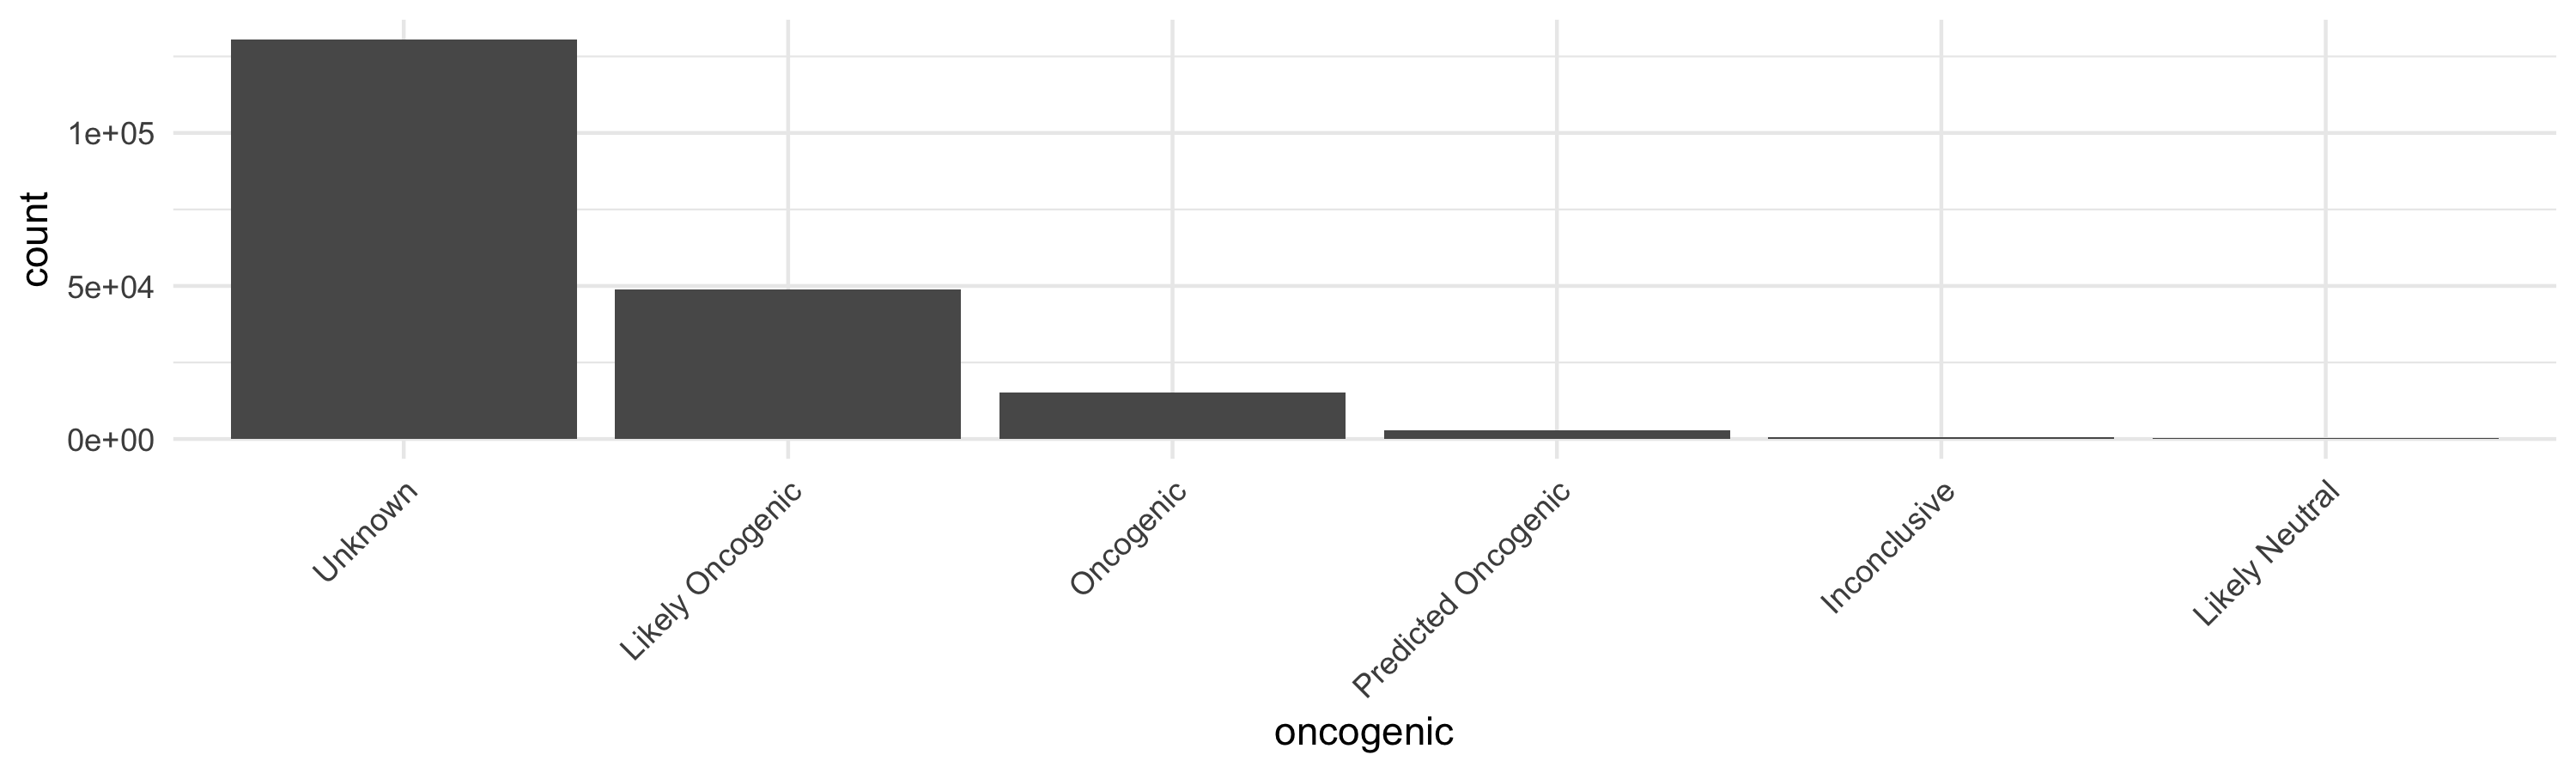

In [5]:
get_table(impact$oncogenic)
plot_histogram(impact, "oncogenic") + tilt_x_label_45()

### `oncogenic` vs `Consequence`

Non of the synonymous mutations are in OncoKB. Among the truncating mutations a lot are predicted as `Likely Oncogenic` while most of the `nonsynonymous_SNV` and nonframeshift insertion/deletion are `Unknown`:

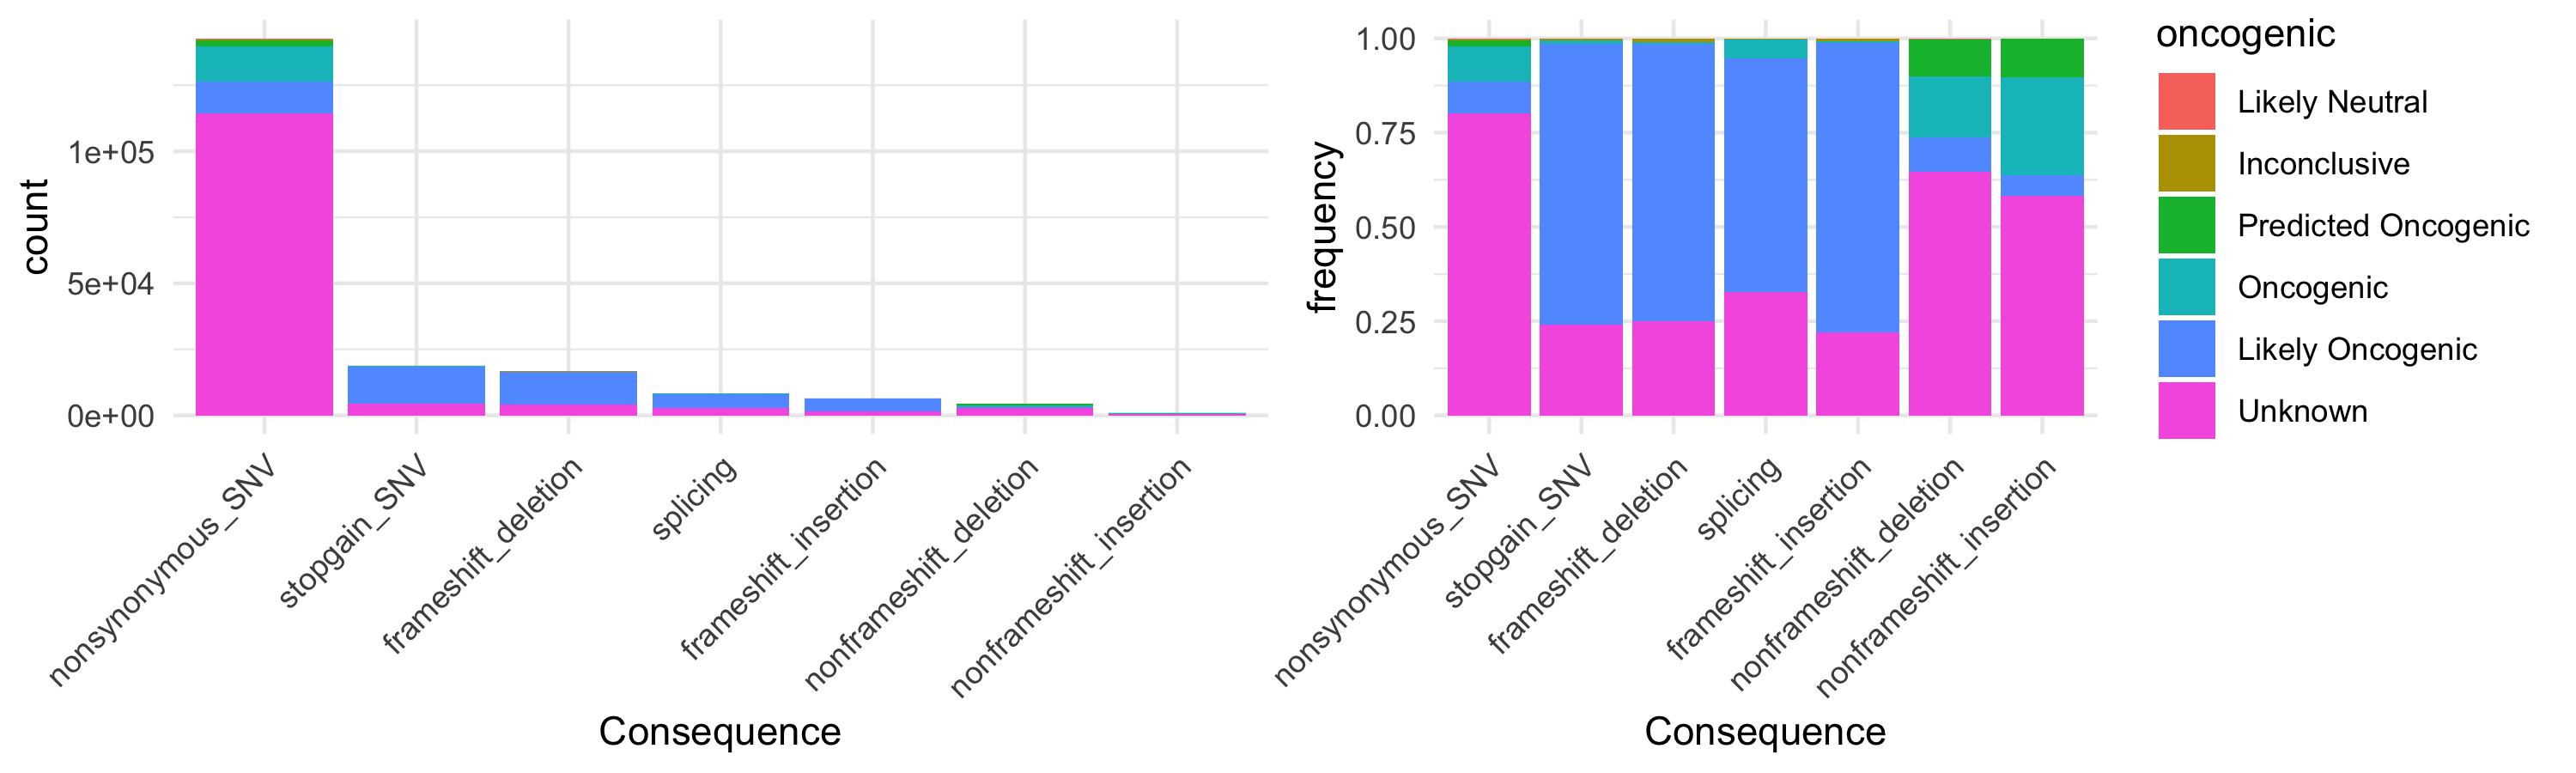

In [6]:
plot_contingency_table_as_histograms(impact, "Consequence", "oncogenic")

### `oncogenic` vs `class`

In [7]:
# create the class feature
impact$class[impact$confidence_class == "OK_NOT_SO" | impact$confidence_class == "UNLIKELY" ] <- "non-somatic"
impact$class[impact$confidence_class == "AUTO_OK"   | impact$confidence_class == "MANUAL_OK"] <- "somatic"
get_table(impact$class)

values,count,freq
somatic,187068,94.4%
non-somatic,11191,5.6%
-- total --,198259,100%


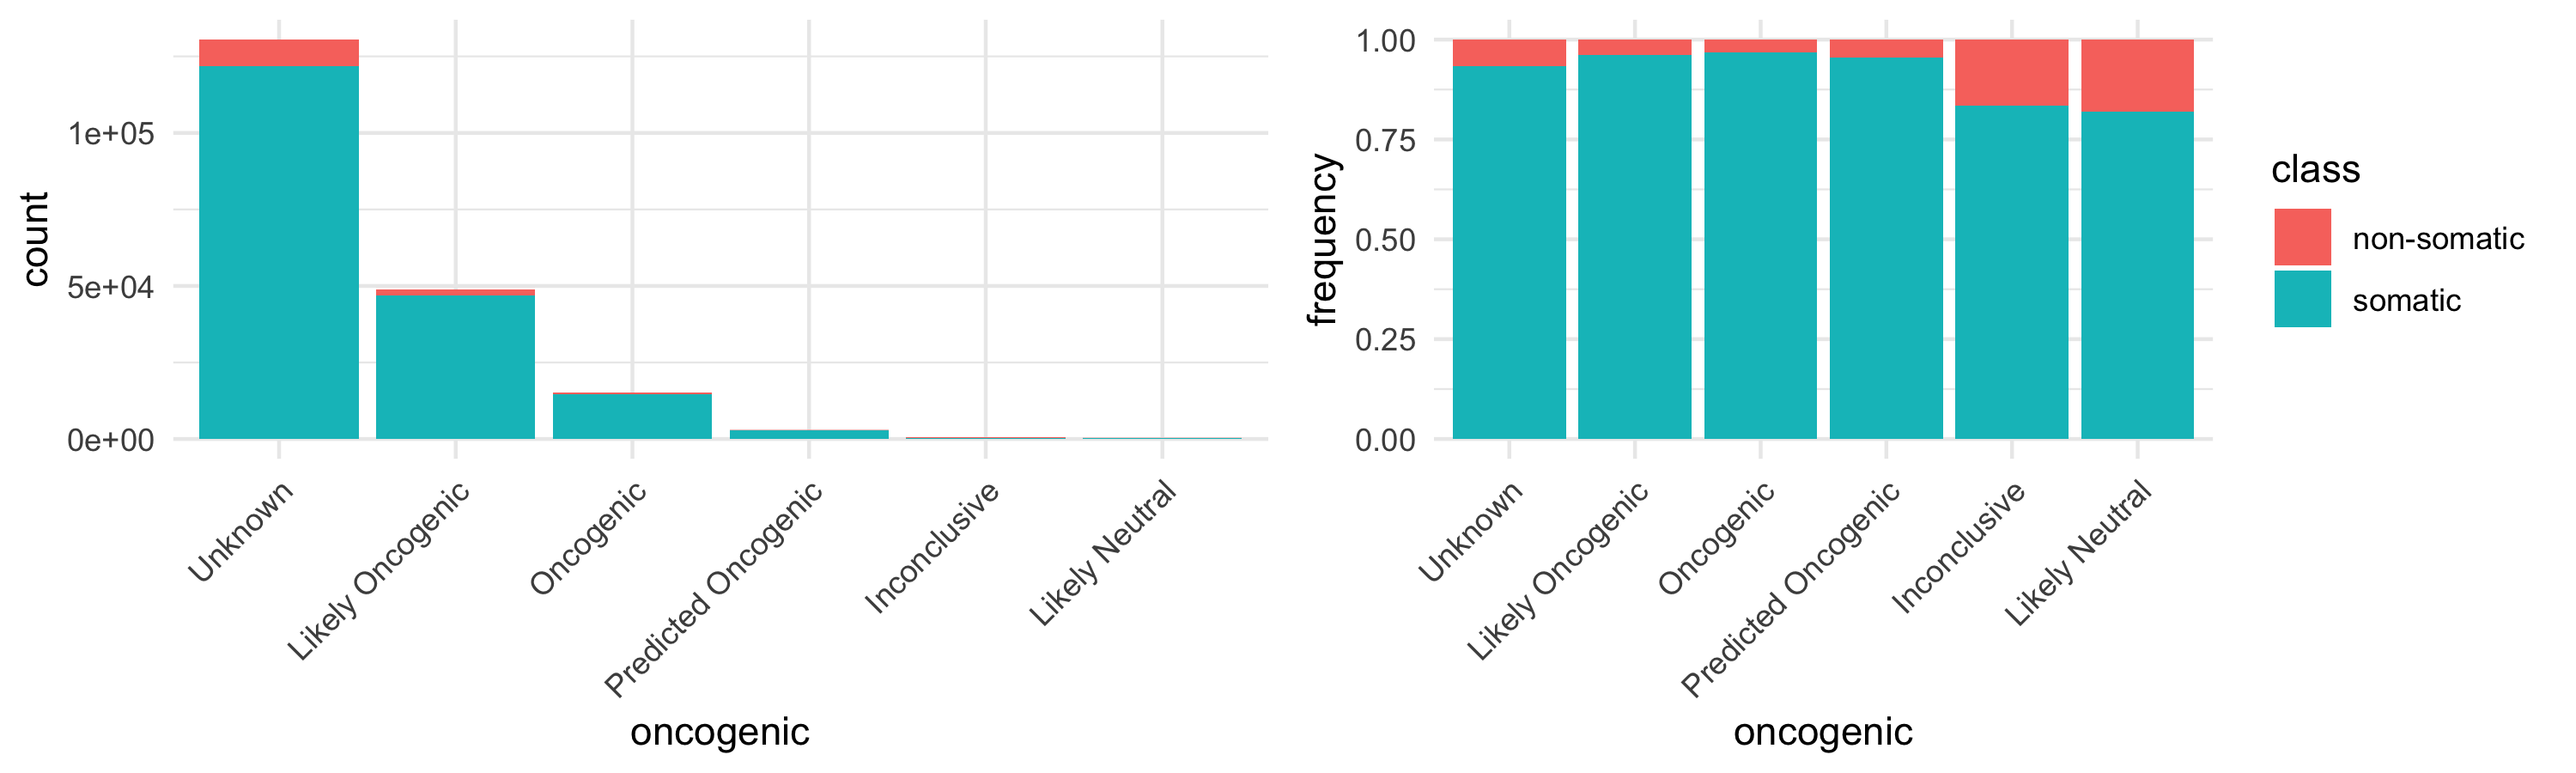

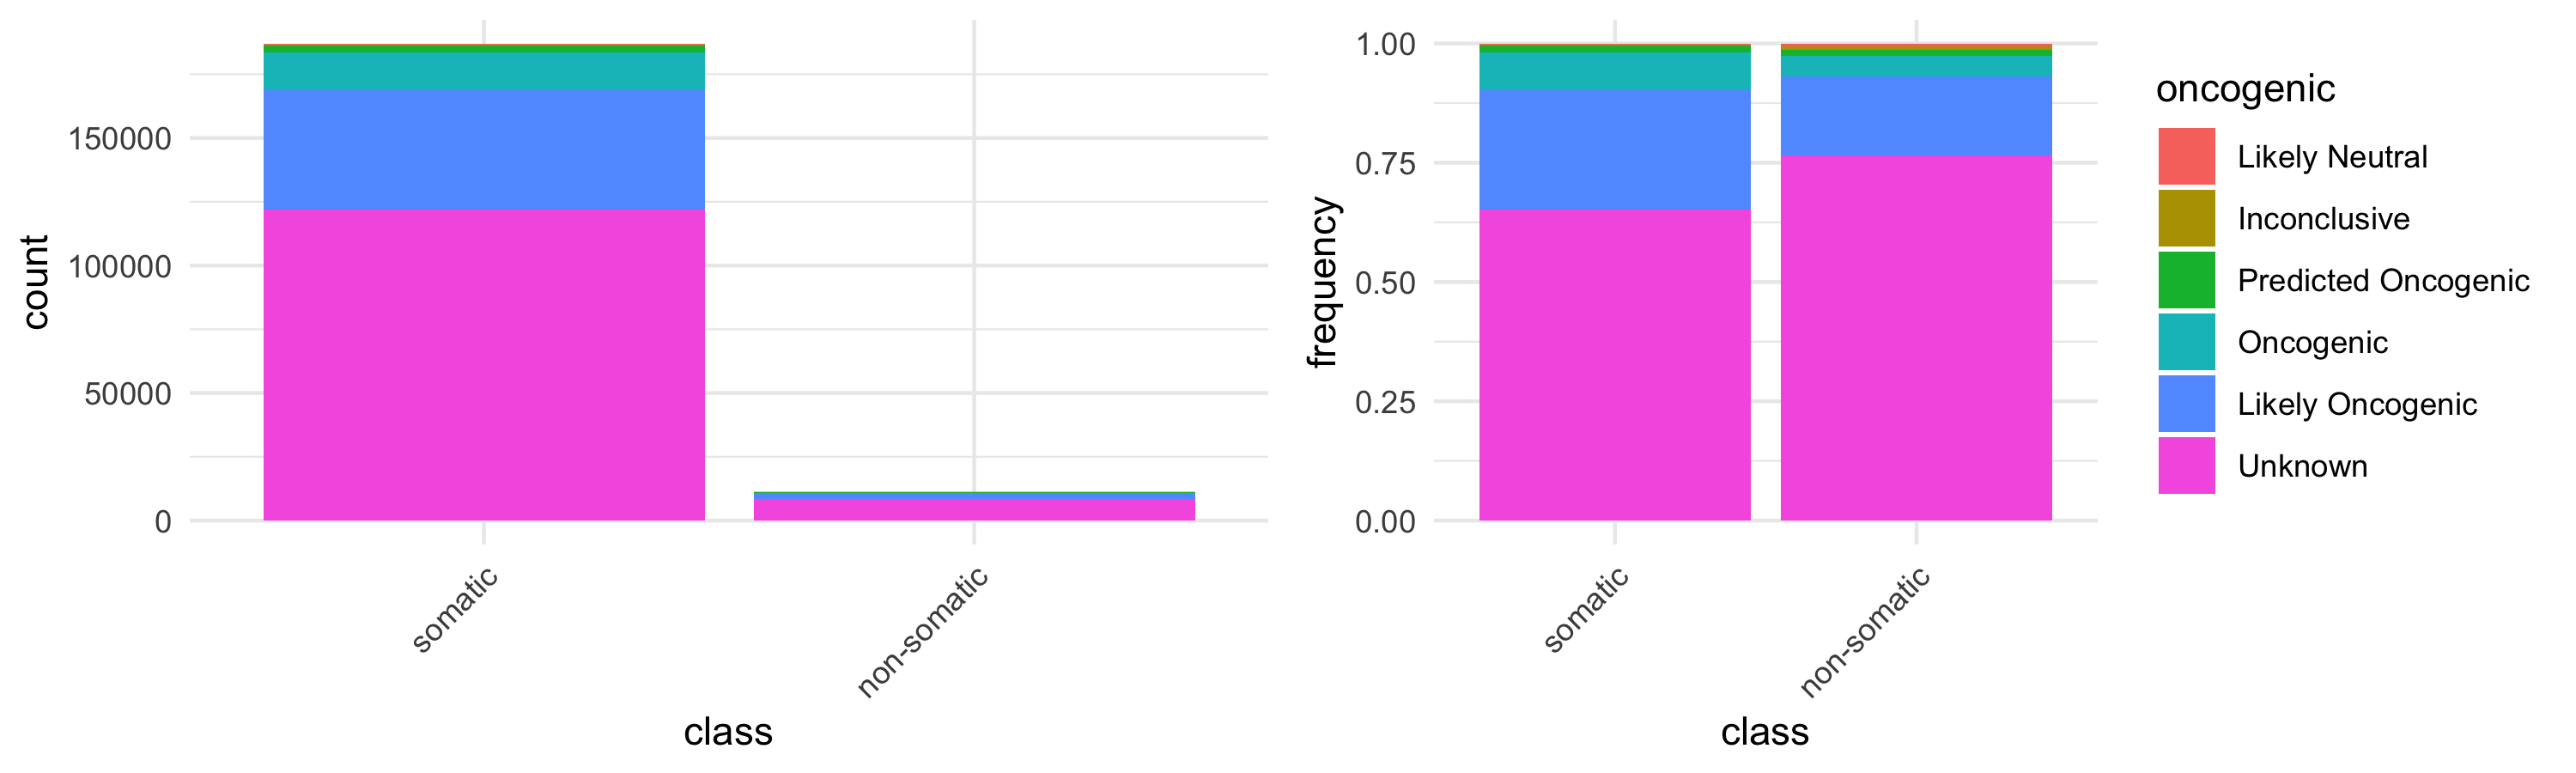

In [8]:
plot_contingency_table_as_histograms(impact, "oncogenic", "class")
plot_contingency_table_as_histograms(impact, "class", "oncogenic")

Some somatic mutations are in OncoKB, however as we saw at the end of [`coding_mutations_analysis.ipynb`](https://github.com/ElsaB/impact-annotator/blob/master/analysis/description/180731_pierre/coding_mutations_analysis.ipynb), there are quite a lot of `non-somatic` mutations (30% of them) that have also been classified as `somatic`:

In [9]:
keys_inconsistent_class <- impact %>% group_by(mut_key) %>%
                                      summarise(n_class = length(unique(class)),
                                                prop_somatic = sum(class == "somatic") / n()) %>%
                                      filter(n_class > 1)

print_count_and_proportion(nrow(impact[impact$class == "non-somatic" &
                                       impact$mut_key %in% keys_inconsistent_class$mut_key,]),
                           nrow(impact[impact$class == "non-somatic",]))

[1] "3352 over 11191 (29.95%)"

In [10]:
dd <- impact
dd$class[dd$class == "non-somatic" & dd$mut_key %in% keys_inconsistent_class$mut_key] <- "uncertain"

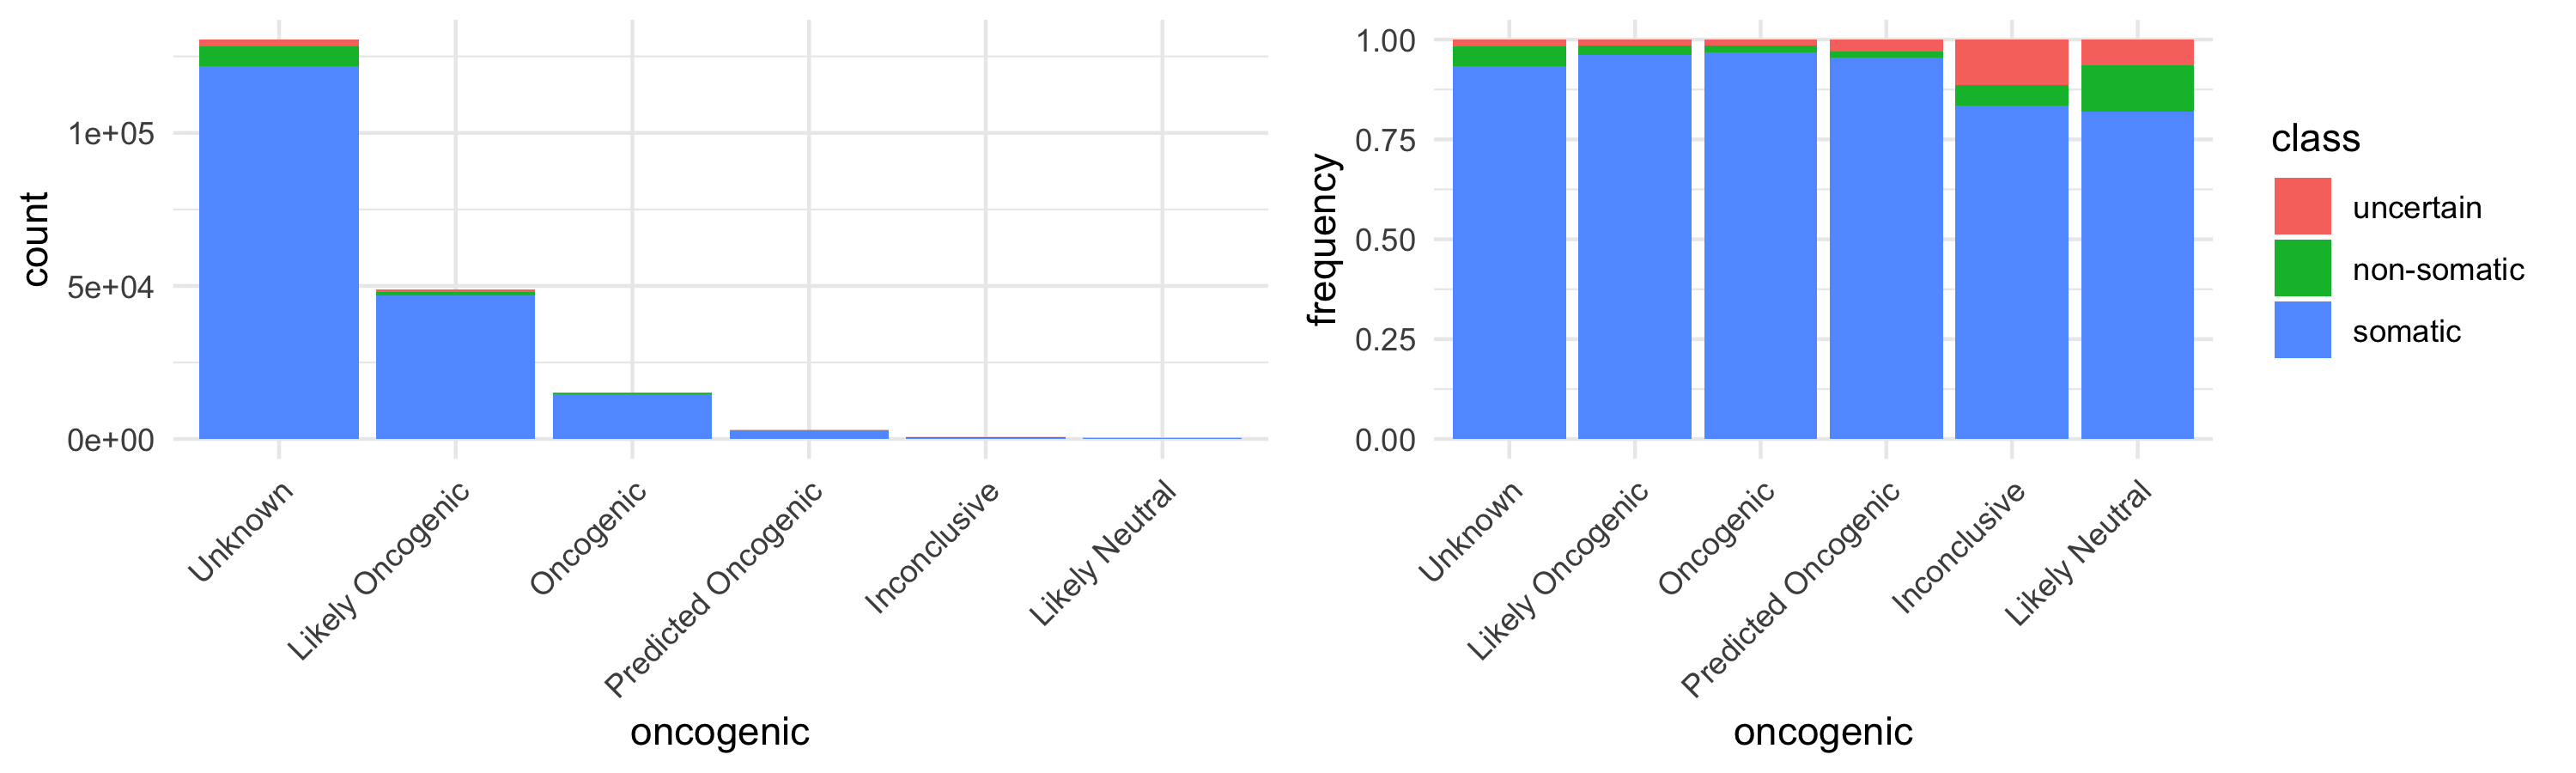

In [11]:
plot_contingency_table_as_histograms(dd, "oncogenic", "class")

In [12]:
nrow(impact[impact$class == "non-somatic" &
                                 impact$oncogenic %in% c("Oncogenic", "Likely Oncogenic", "Predicted Oncogenic")& dd$mut_key %in% keys_inconsistent_class$mut_key,] )

[1] 1050

In [13]:
non_somatic_and_driver <- impact[impact$class == "non-somatic" &
                                 impact$oncogenic %in% c("Oncogenic", "Likely Oncogenic", "Predicted Oncogenic"),]

print_count_and_proportion(nrow(non_somatic_and_driver), nrow(impact[impact$class == "non-somatic",]))

[1] "2478 over 11191 (22.14%)"

[1] "2478 over 198259 (1.25%)"

[1] "Number of different genes:  182"


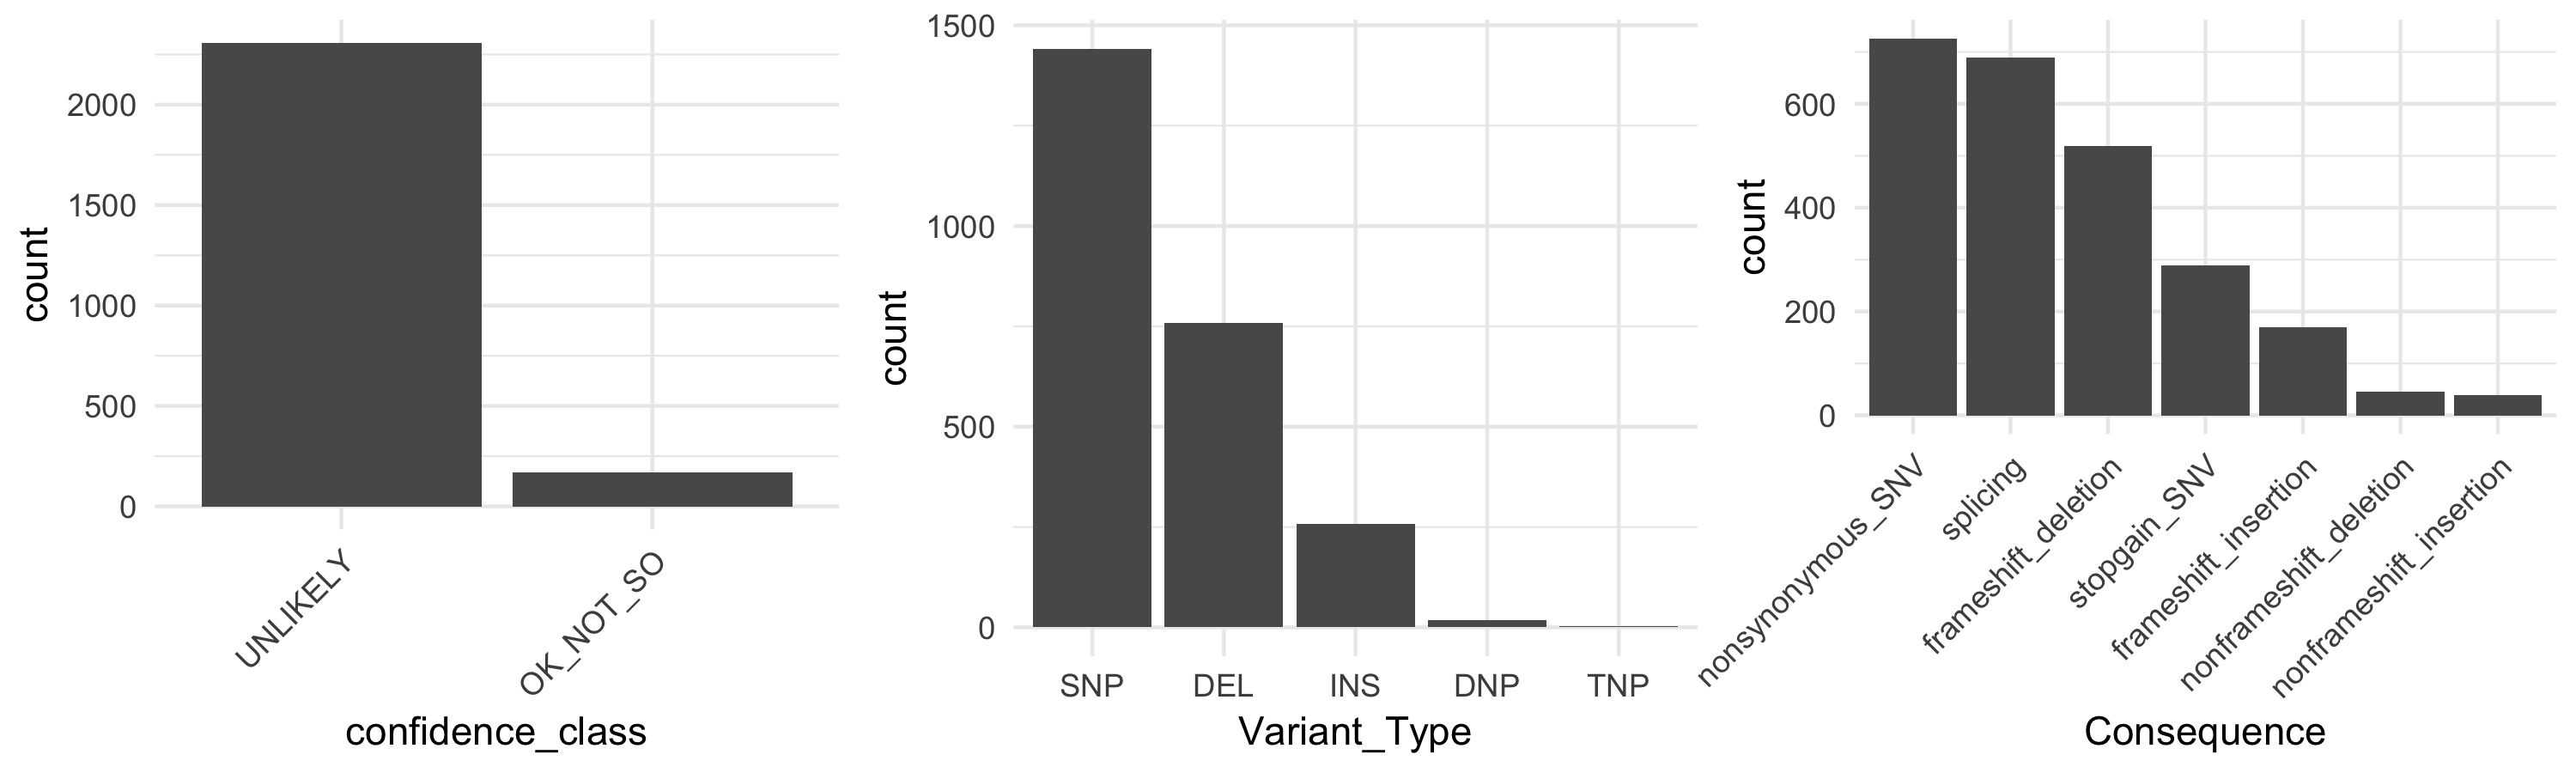

In [14]:
non_somatic_and_driver <- impact[impact$class == "non-somatic" &
                                 impact$oncogenic %in% c("Oncogenic", "Likely Oncogenic", "Predicted Oncogenic"),]

print_count_and_proportion(nrow(non_somatic_and_driver), nrow(impact))
get_possible_correlations(non_somatic_and_driver)

They have a relatively low `cosmic_count` for the majority ($\leq 2$ for 70% of them):

In [15]:
summary(non_somatic_and_driver$cosmic_count)
quantile(non_somatic_and_driver$cosmic_count, c(0.7, 0.8, 0.9, 0.95, 0.99))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     0.0     0.0   350.7     3.0 33328.0 

70%   80%   90%   95%   99% 
    2     5    25    91 20034

### Create the `driver` feature

We create the `driver` feature that indicates if a mutation has been classified as `Oncogenic`, `Likely Oncogenic` or `Predicted Oncogenic` by OncoKB. Around 33% of our mutations are known drivers in OncoKB:

In [16]:
impact$driver <- "no"
impact$driver[impact$oncogenic %in% c("Oncogenic", "Likely Oncogenic", "Predicted Oncogenic")] <- "yes"

print_count_and_proportion(nrow(impact[impact$driver == "yes",]), nrow(impact))

[1] "66855 over 198259 (33.72%)"

Warning: driver mutations include some non-somatic mutations.

## Create and study the `label` feature

### Create the feature

We create the `label` feature that indicates if a mutation is non-somatic, passenger or driver:

In [17]:
impact$label[impact$class == "non-somatic"] <- "non-somatic"
impact$label[impact$class != "non-somatic" & impact$driver == "no" ] <- "somatic_passenger"
impact$label[impact$class != "non-somatic" & impact$driver == "yes"] <- "somatic_driver"

values,count,freq
somatic_passenger,122691,61.9%
somatic_driver,64377,32.5%
non-somatic,11191,5.6%
-- total --,198259,100%


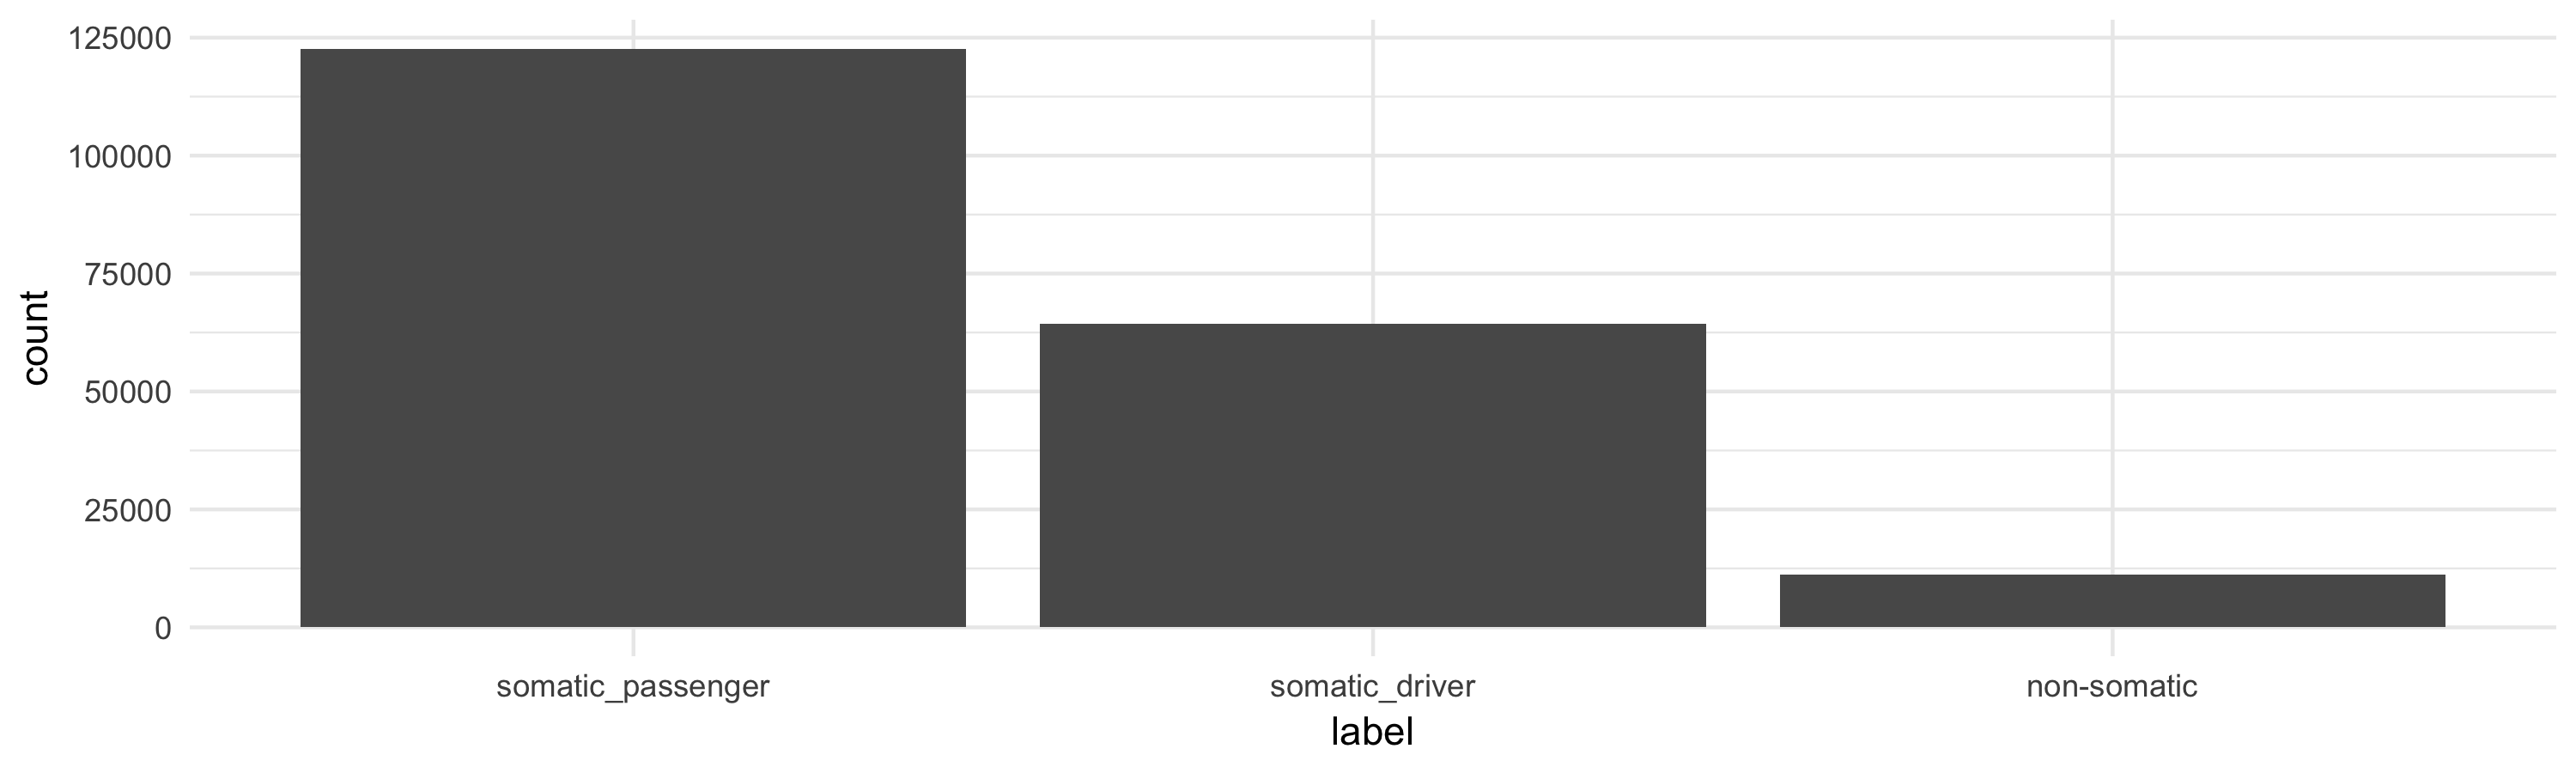

In [18]:
get_table(impact$label)
plot_histogram(impact, "label")

### `label` vs `Consequence`

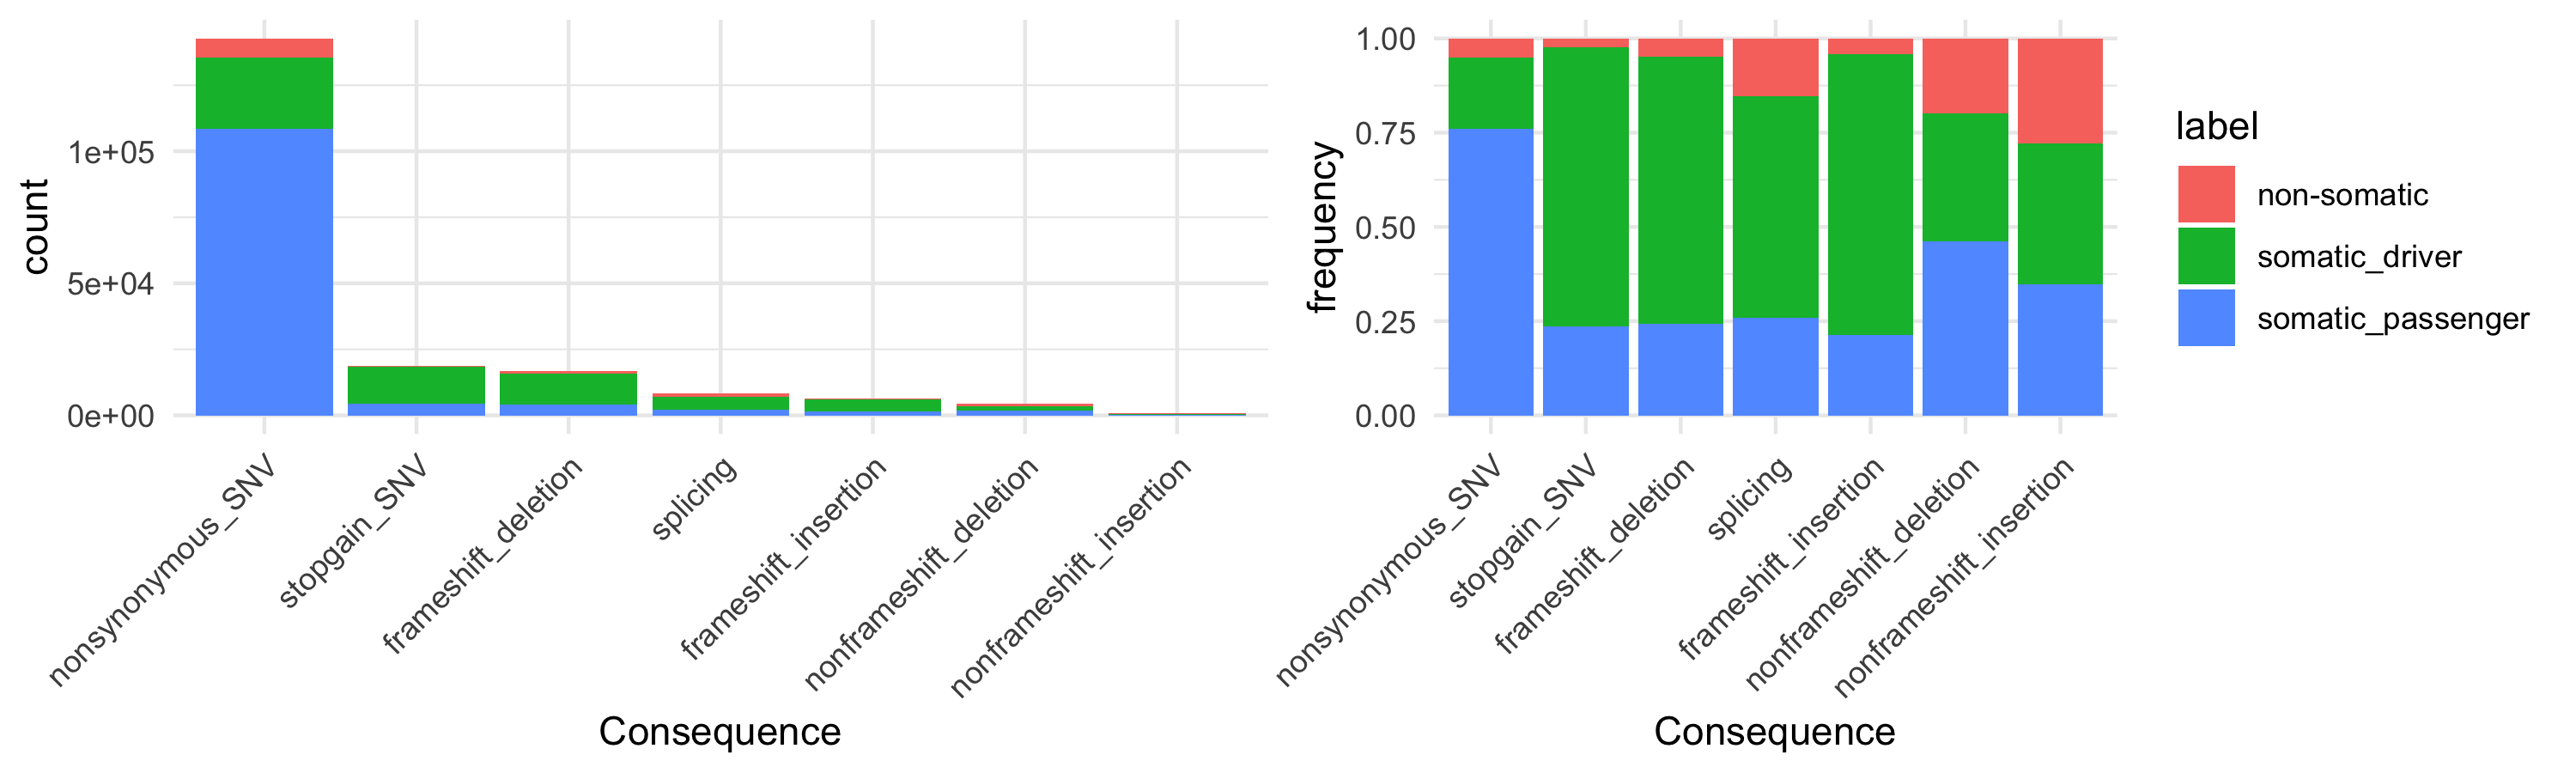

In [19]:
plot_contingency_table_as_histograms(impact, "Consequence", "label")

### Comparison of the `t_vaf`, `Kaviar_AF` and `cosmic_count`

In [20]:
impact <- impact[impact$Consequence != "synonymous_SNV",]

Distribution of `t_vaf`, `Kaviar_AF` and `cosmic_count` for the different `label` (warning the second and last plot have a sqrt x and sqrt y scale):

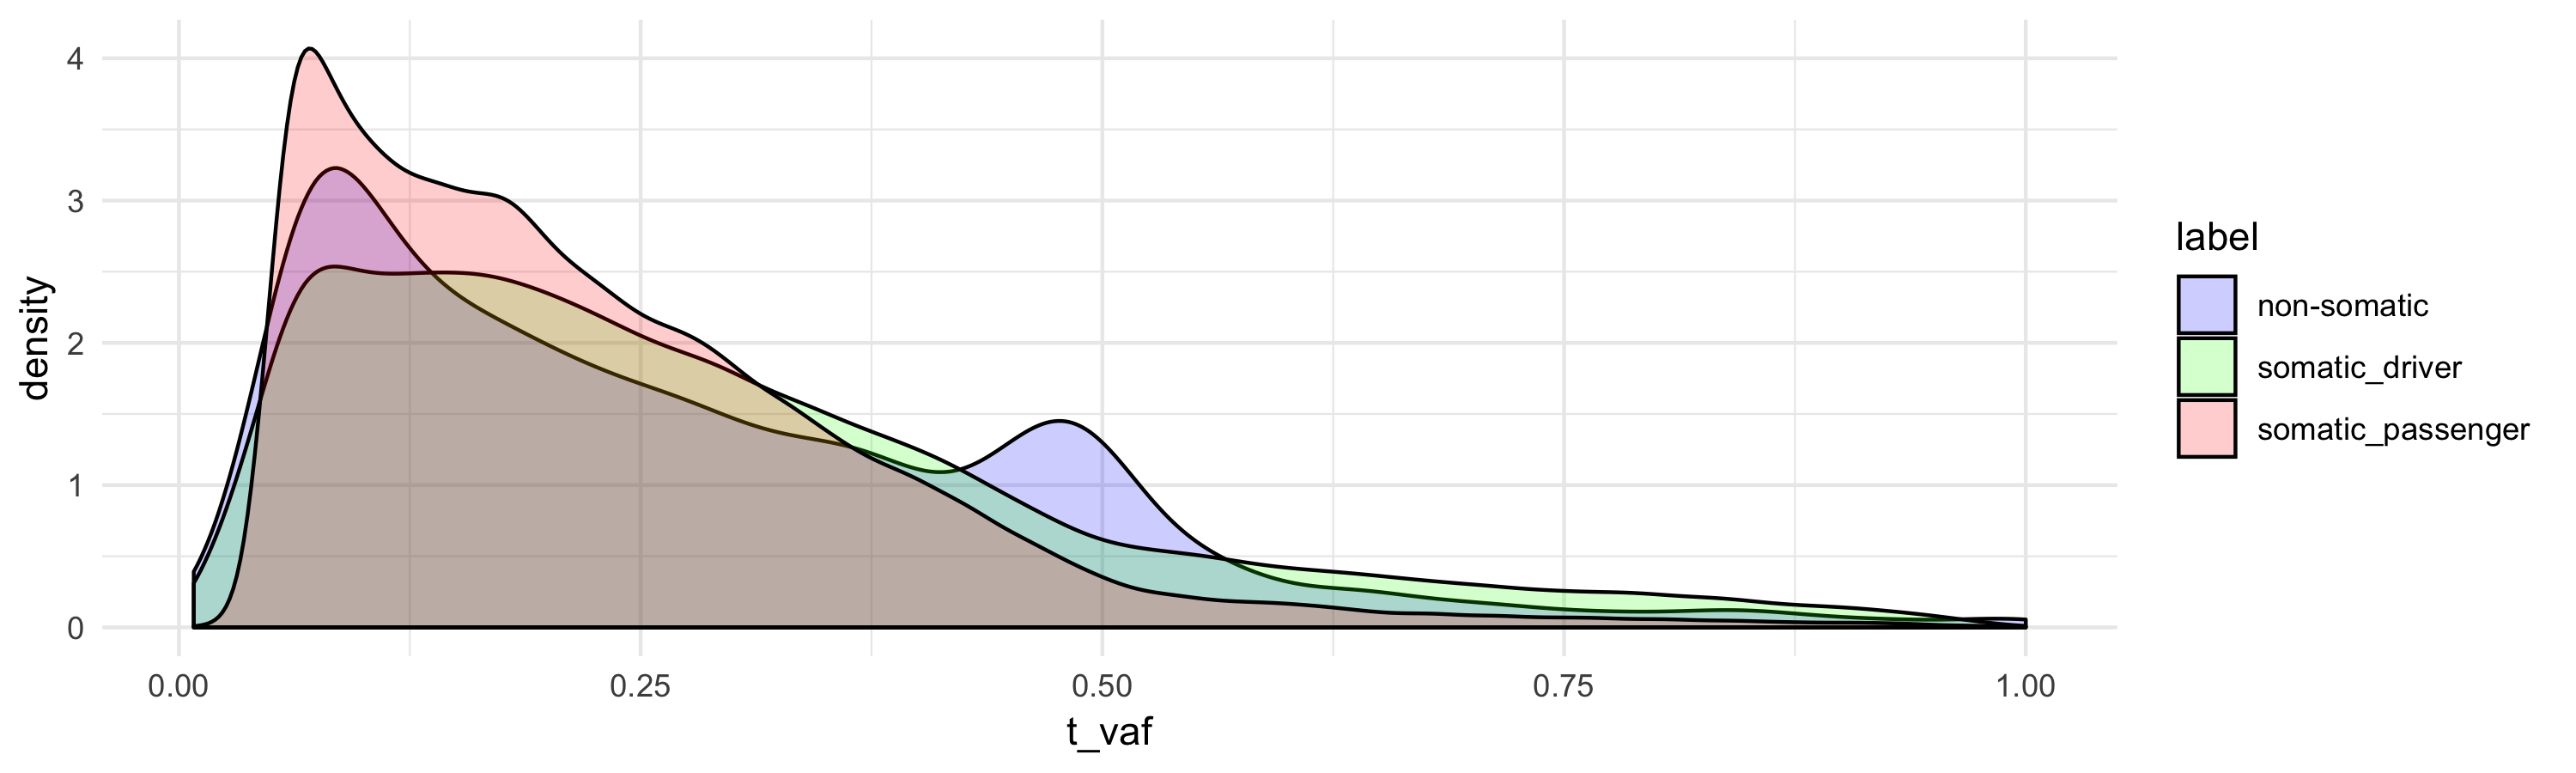

In [21]:
plot_density(impact, "t_vaf", "label")

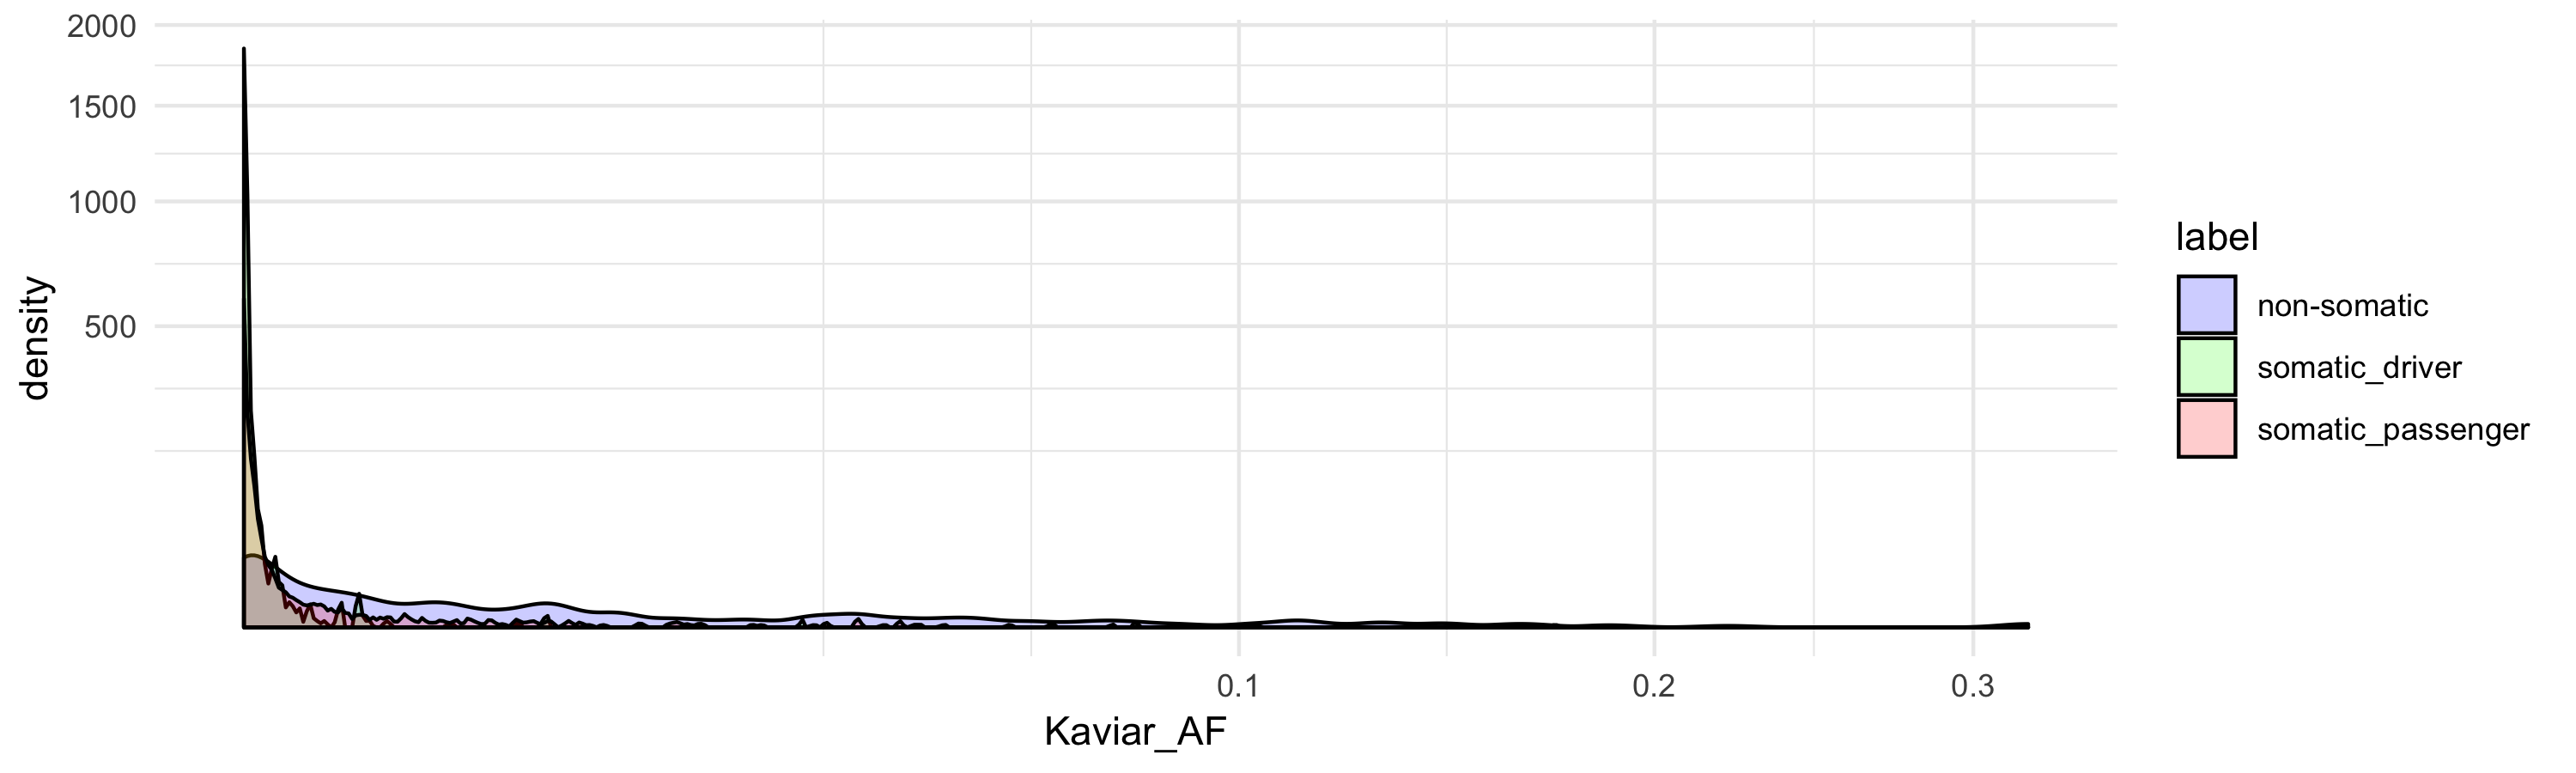

In [22]:
plot_density(impact[impact$Kaviar_AF != 0,], "Kaviar_AF", "label") + scale_x_sqrt() + scale_y_sqrt()

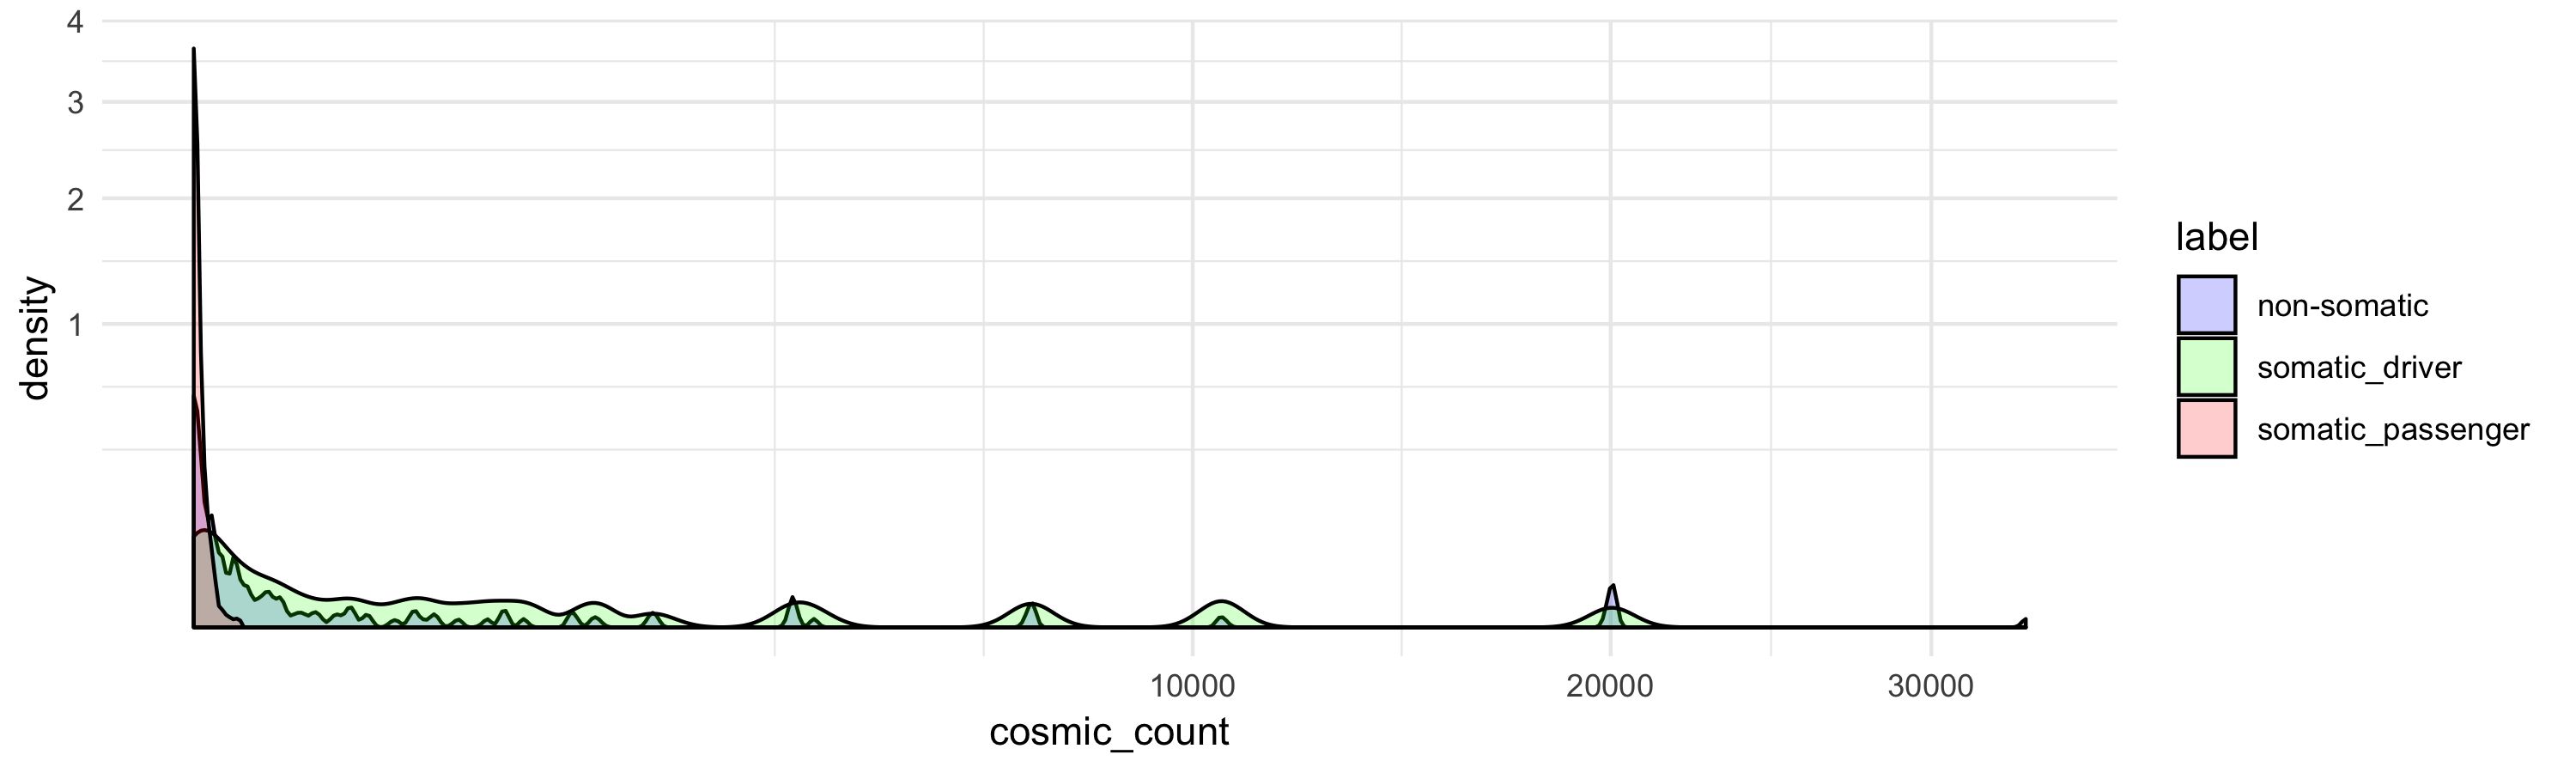

In [23]:
plot_density(impact[impact$cosmic_count != 0,], "cosmic_count", "label") + scale_x_sqrt() + scale_y_sqrt()

## Study of `cosmic_count` for driver vs non-driver mutations

### non-driver mutations

There is not a single variant that is not in OncoKB but have a high `cosmic_count` (the maximum among non-drivers mutations is 28 but the mean is 0.1423), see the plot of the `cosmic_count` density below for all the impact mutations and for the non-drivers mutations only (warning this is a sqrt x and y scale):

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     0.0     0.0   214.9     1.0 33328.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.1409  0.0000 28.0000 

[1] "465 over 131404 (0.35%)"

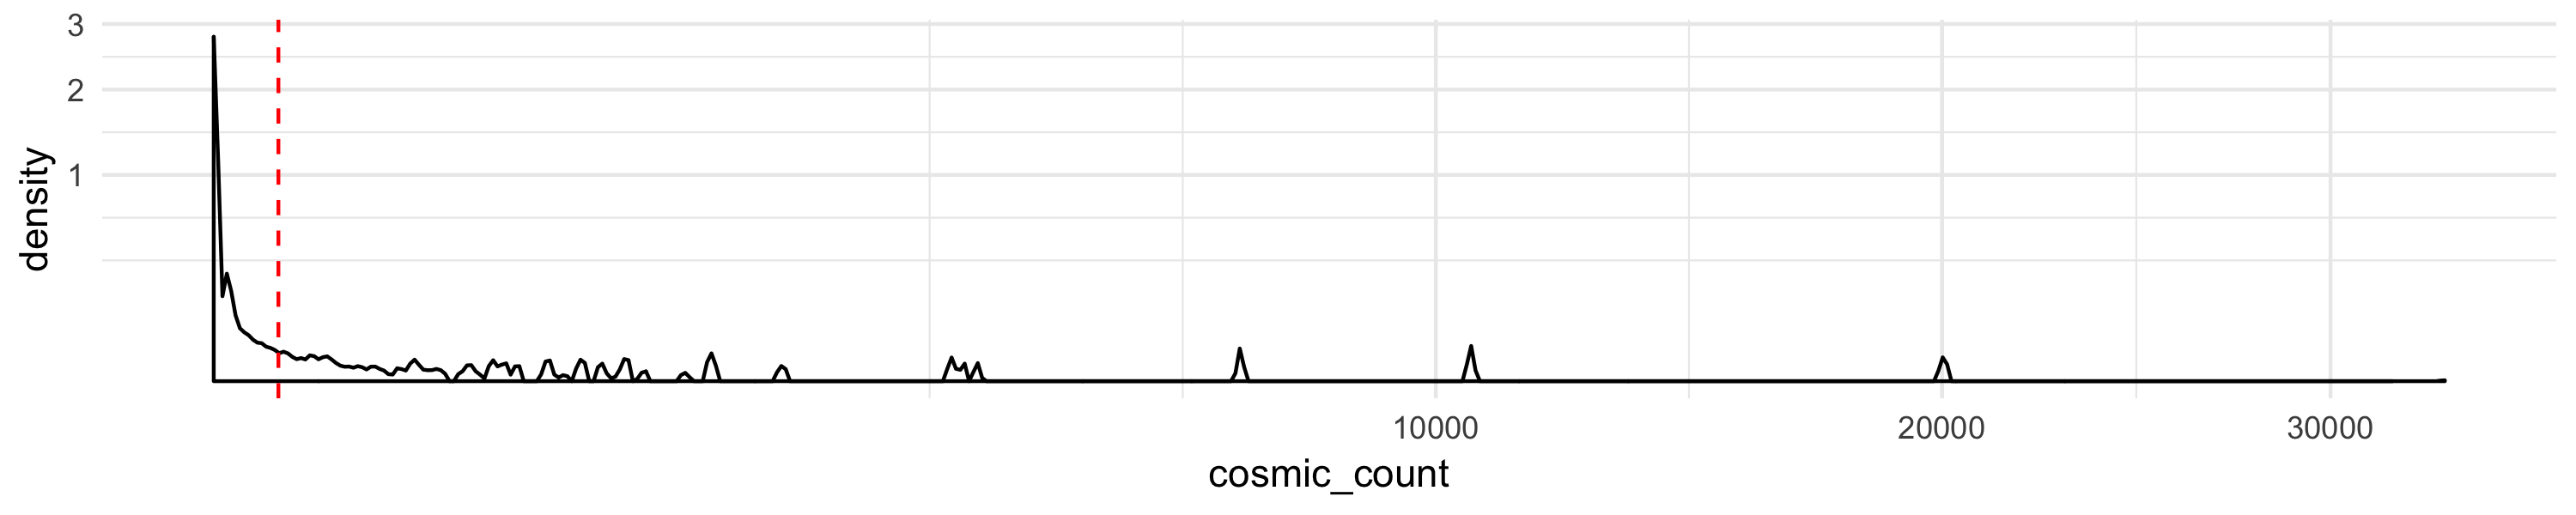

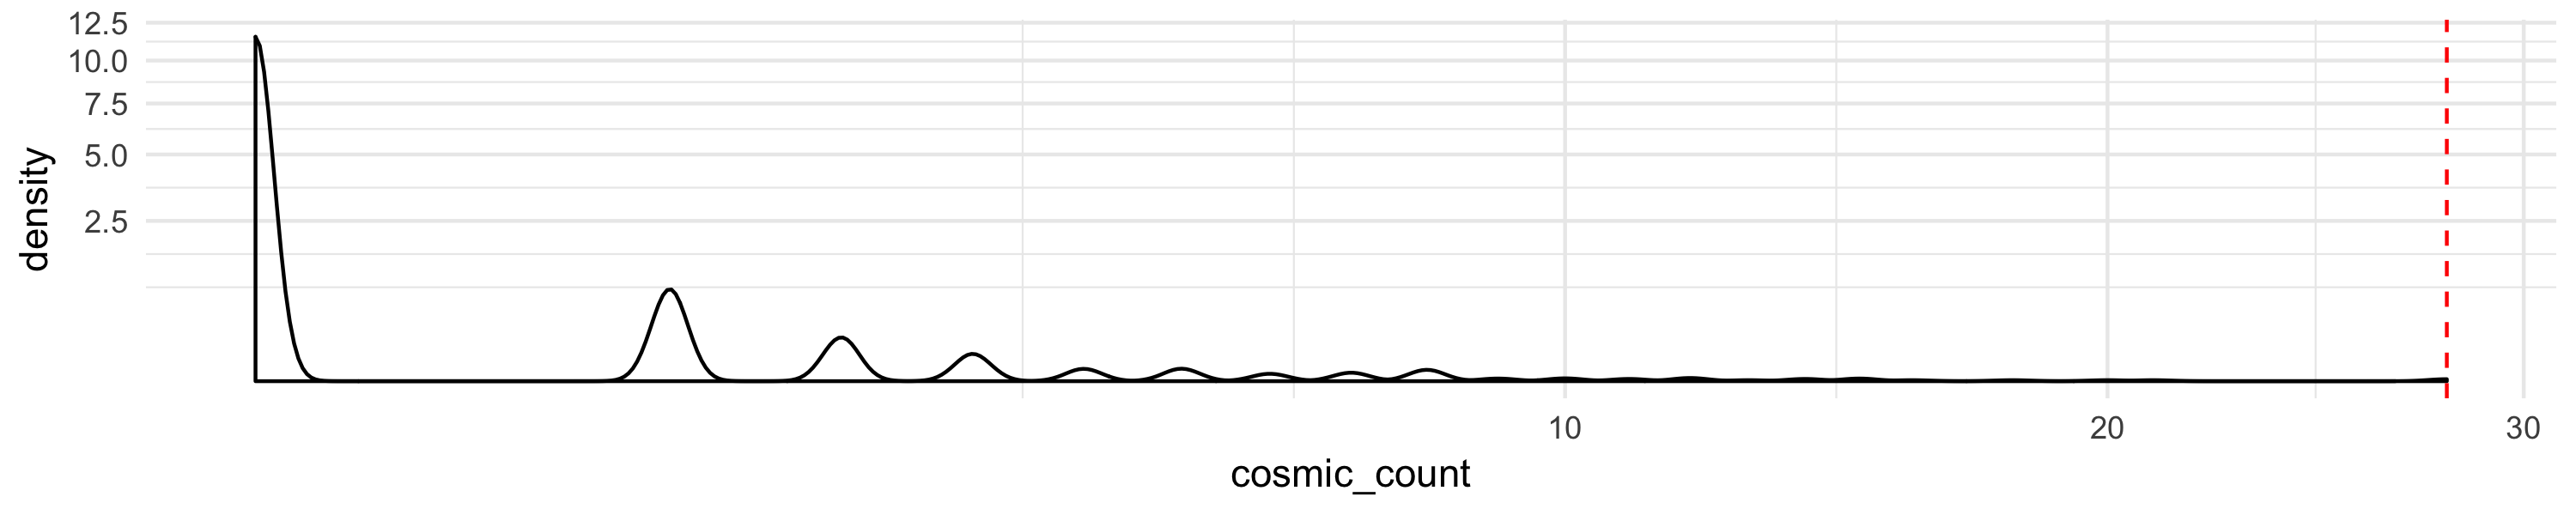

In [24]:
summary(impact$cosmic_count)
summary(impact[impact$driver == "no",]$cosmic_count)

# number of non-driver mutations having a cosmic_count >= 10 among the non-driver mutations
print_count_and_proportion(nrow(impact[impact$driver == "no" & impact$cosmic_count >= 5,]),
                           nrow(impact[impact$driver == "no",]))

max_non_drivers_cosmic_count = max(impact$cosmic_count[impact$driver == "no"])

plot_density(impact, "cosmic_count", lines = max_non_drivers_cosmic_count, height = 2) +
        scale_x_sqrt() + scale_y_sqrt()
plot_density(impact[impact$driver == "no",], "cosmic_count", lines = max_non_drivers_cosmic_count, height = 2) +
        scale_x_sqrt() + scale_y_sqrt()

Low mutation count for the highest `cosmic_count`:

In [25]:
impact %>% filter(driver == "no" & cosmic_count >= 12) %>%
           group_by(mut_key) %>%
           summarise(Hugo_Symbol = unique(Hugo_Symbol),
                     HGVSp_Short = unique(HGVSp_Short),
                     cosmic_count = unique(cosmic_count),
                     count = n(),
                     oncogenic = unique(oncogenic)) %>%
           arrange(- cosmic_count)

mut_key,Hugo_Symbol,HGVSp_Short,cosmic_count,count,oncogenic
19_1223125_C_G,STK11,p.F354L,28,4,Likely Neutral
12_112888163_G_T,PTPN11,p.G60V,21,1,Unknown
9_139399389_A_G,NOTCH1,p.L1585P,20,1,Unknown
4_106197285_T_C,TET2,p.I1873T,18,1,Unknown
X_48649606_AG_-,GATA1,p.V32Ffs*7,16,1,Unknown
20_31023821_G_T,ASXL1,p.E1102D,15,7,Unknown
11_119148919_T_C,CBL,p.L380P,14,1,Unknown
3_38182032_C_G,MYD88,p.S219C,14,4,Unknown
21_36231792_C_T,RUNX1,p.D198N,13,1,Unknown
11_108175462_G_A,ATM,p.D1853N,12,8,Likely Neutral


Relatively low `cosmic_count` for the high mutation count:

In [26]:
impact %>% filter(driver == "no" & cosmic_count >= 5) %>%
           group_by(mut_key) %>%
           summarise(Hugo_Symbol = unique(Hugo_Symbol),
                     HGVSp_Short = unique(HGVSp_Short),
                     cosmic_count = unique(cosmic_count),
                     count = n(),
                     oncogenic = unique(oncogenic)) %>%
           filter(count >= 10) %>%
           arrange(- count)

mut_key,Hugo_Symbol,HGVSp_Short,cosmic_count,count,oncogenic
1_120612013_G_A,NOTCH2,p.A3V,8,55,Unknown
12_416953_T_-,KDM5A,p.G1200Dfs*9,8,52,Unknown
7_2968323_G_-,CARD11,p.R555Gfs*45,5,52,Unknown
12_57860075_G_-,GLI1,p.G274Afs*6,7,48,Unknown
1_36935323_G_-,CSF3R,p.S469Afs*22,5,18,Unknown
16_72830903_CT_-,ZFHX3,p.R1893Gfs*35,5,14,Unknown
16_9858517_C_T,GRIN2A,p.E962K,5,11,Unknown


### driver mutations

However, there are variant that are classified as drivers but have a really low `cosmic_count` (actually 42% of them have a null `cosmic_count`):

In [27]:
summary(impact[impact$driver == "yes",]$cosmic_count)

# number of driver mutations having a cosmic_count = 0 among the driver mutations
print_count_and_proportion(nrow(impact[impact$driver == "yes" & impact$cosmic_count == 0,]),
                           nrow(impact[impact$driver == "yes",]))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       1     637      38   33328 

[1] "28628 over 66855 (42.82%)"

In [28]:
quantile(impact$cosmic_count[impact$driver == "yes"], probs = c(0.5, 0.7, 0.8, 0.9))

50% 70% 80% 90% 
  1  18  86 904

## Study of reccurence among driver mutations

We will follow the methodology from `coding_mutations_analysis.ipynb`.

### Identify the reccurent mutations

We need to study the reccurence of mutations taking care not to consider a mutation as recurrent if it comes frome the same patient. To do so we will group the rows by patient, and select only the distinct mutations for each patient:

In [29]:
impact$patient_id <- substr(impact$Tumor_Sample_Barcode, 1, 9) # create a patient id
impact_unique_mut_keys_per_patient <- as.data.frame(impact %>% group_by(patient_id) %>%
                                                               select(patient_id,
                                                                      mut_key,
                                                                      Hugo_Symbol,
                                                                      Consequence,
                                                                      Variant_Type,
                                                                      class,
                                                                      driver,
                                                                      oncogenic) %>%
                                                               filter(! duplicated(mut_key)))
head(impact_unique_mut_keys_per_patient)

patient_id,mut_key,Hugo_Symbol,Consequence,Variant_Type,class,driver,oncogenic
P-0000012,17_7577515_T_G,TP53,nonsynonymous_SNV,SNP,somatic,yes,Likely Oncogenic
P-0000012,1_46521514_G_C,PIK3R3,nonsynonymous_SNV,SNP,somatic,no,Unknown
P-0000012,3_142178126_C_A,ATR,nonsynonymous_SNV,SNP,somatic,no,Unknown
P-0000012,4_55139732_T_A,PDGFRA,nonsynonymous_SNV,SNP,somatic,no,Unknown
P-0000012,4_153249542_C_A,FBXW7,splicing,SNP,somatic,yes,Likely Oncogenic
P-0000012,4_153332775_C_A,FBXW7,stopgain_SNV,SNP,somatic,yes,Likely Oncogenic


In [30]:
drivers <- impact_unique_mut_keys_per_patient[impact_unique_mut_keys_per_patient$driver == "yes",]
print_count_and_proportion(nrow(drivers), nrow(impact_unique_mut_keys_per_patient))

[1] "63657 over 190526 (33.41%)"

In [31]:
mut_key_info <- as.data.frame(drivers %>% group_by(mut_key) %>% summarise(count = n(),
                                                                          Hugo_Symbol = unique(Hugo_Symbol)))
head(mut_key_info)

mut_key,count,Hugo_Symbol
1_11168338_C_T,1,MTOR
1_11169361_C_G,1,MTOR
1_11169375_A_C,1,MTOR
1_11169376_A_T,3,MTOR
1_11169377_T_A,3,MTOR
1_11174395_A_C,4,MTOR


In [32]:
for (threshold in c(2, 3, 5, 10)) {
    
    mut_key_info_threshold <- mut_key_info[mut_key_info$count >= threshold,]
    
    impact_unique_mut_keys_per_patient_threshold <- impact_unique_mut_keys_per_patient[
                                                            impact_unique_mut_keys_per_patient$mut_key
                                                            %in% mut_key_info_threshold$mut_key,]
    
    print(sprintf("%s keys are shared by at least %2d samples [%s rows concerned]",
                  print_count_and_proportion(nrow(mut_key_info_threshold), nrow(mut_key_info), 5, 5),
                  threshold,
                  print_count_and_proportion(nrow(impact_unique_mut_keys_per_patient_threshold),
                                             nrow(impact_unique_mut_keys_per_patient))))
}

[1] " 5994 over 27159 (22.07%) keys are shared by at least  2 samples [42492 over 190526 (22.30%) rows concerned]"
[1] " 3225 over 27159 (11.87%) keys are shared by at least  3 samples [36954 over 190526 (19.40%) rows concerned]"
[1] " 1631 over 27159 ( 6.01%) keys are shared by at least  5 samples [31617 over 190526 (16.59%) rows concerned]"
[1] "  715 over 27159 ( 2.63%) keys are shared by at least 10 samples [25827 over 190526 (13.56%) rows concerned]"


Distribution of the mutations key count for the mutations present in at least 2 samples (warning this is a sqrt x and y scale):

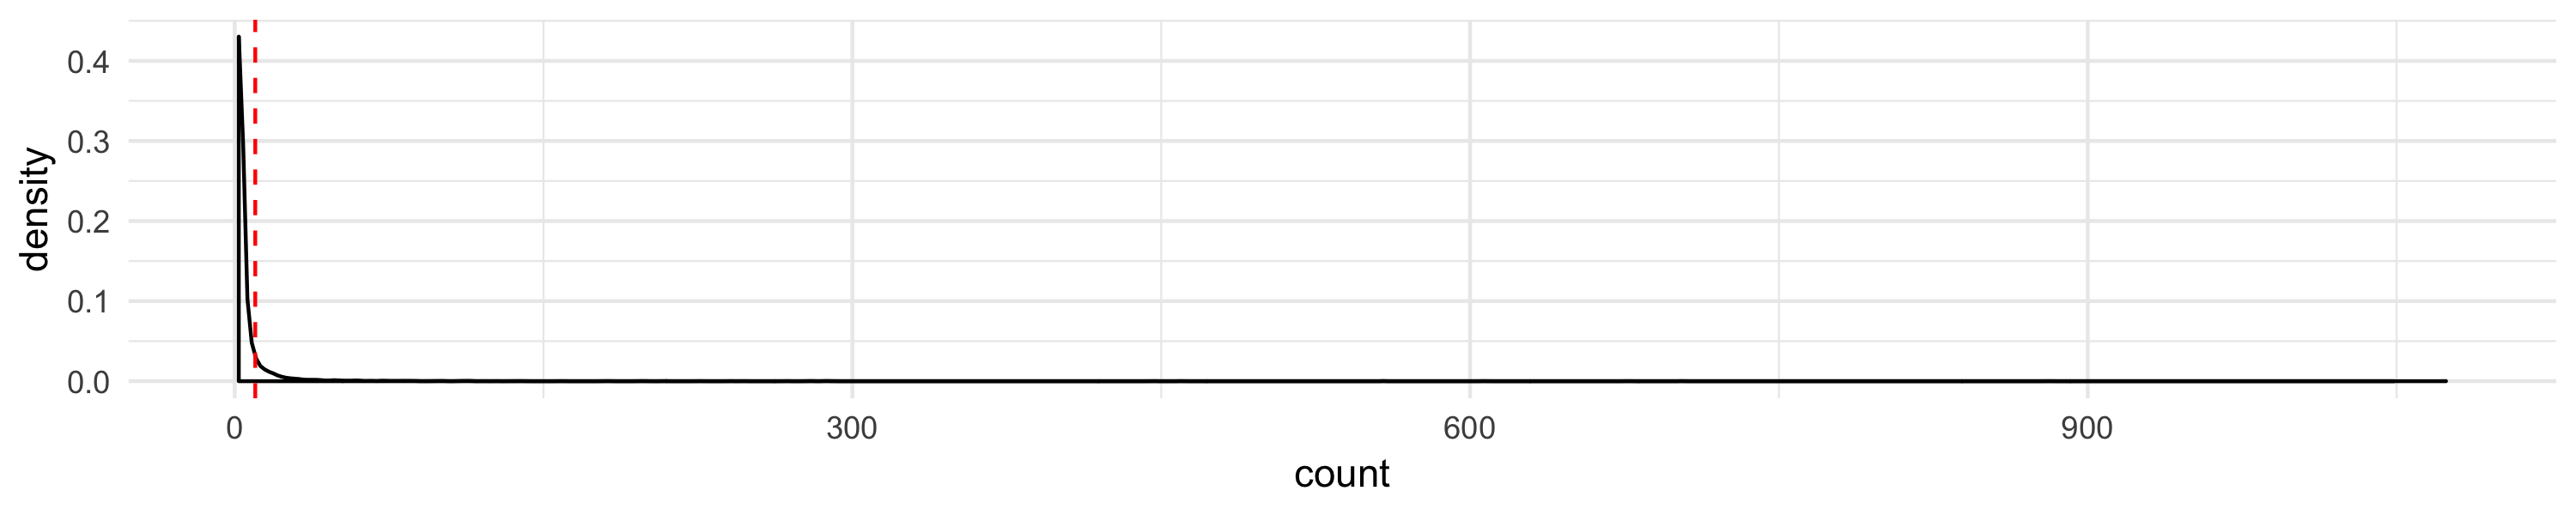

In [33]:
repeated_key <- mut_key_info[mut_key_info$count >= 2,] # keys shared by at least 2 samples
plot_density(repeated_key, "count", lines = 10, height = 2)

### Sudy the reccurent mutations genes

In [34]:
length(unique(repeated_key$Hugo_Symbol))

[1] 256

Here is a plot of the genes that are the most mutated **accross the mutation keys**:

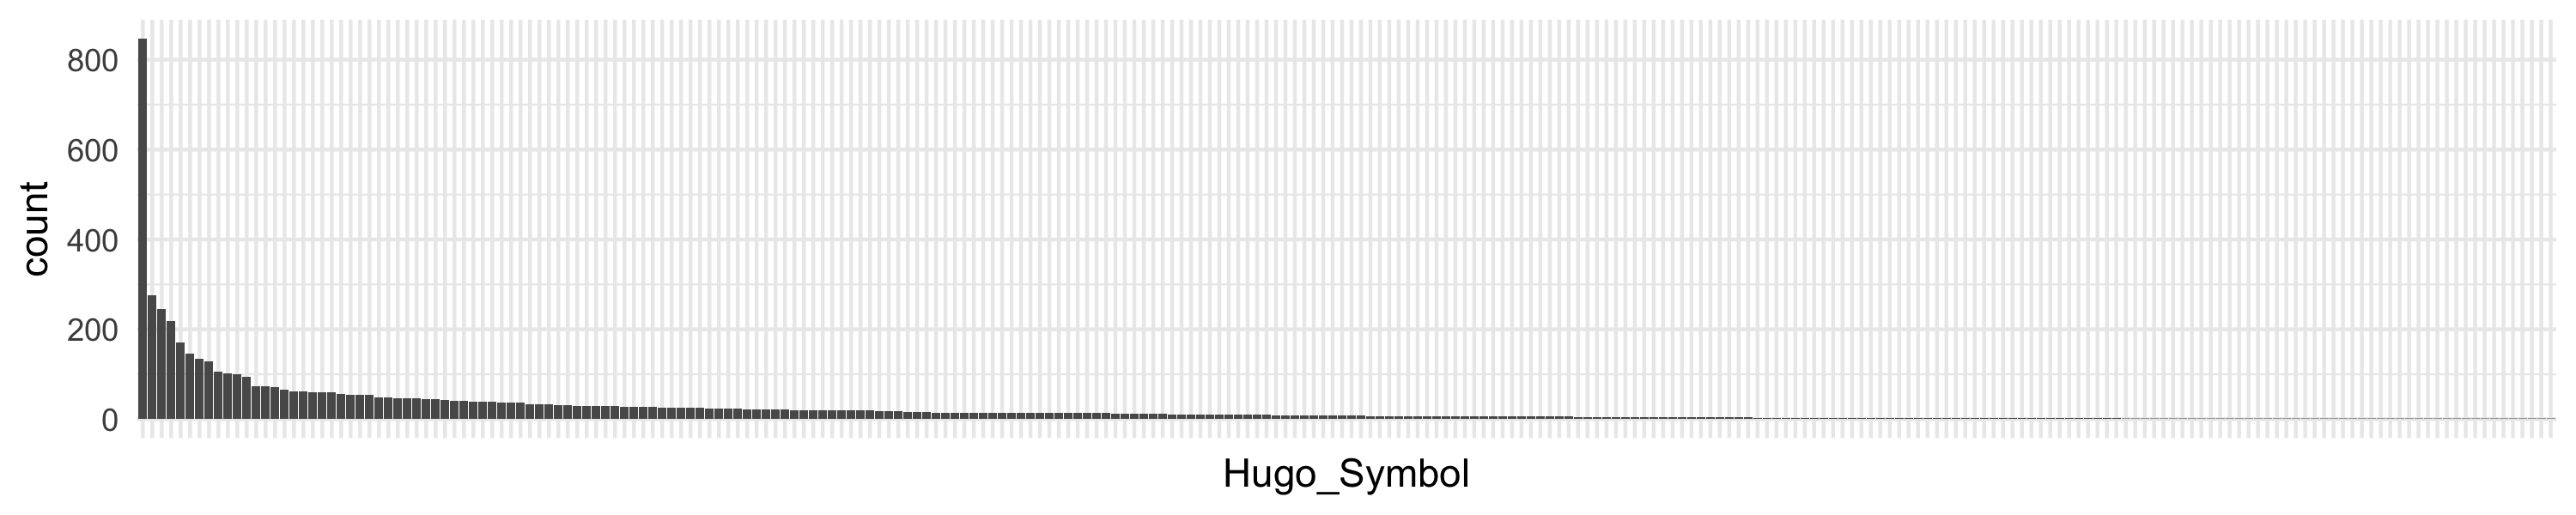

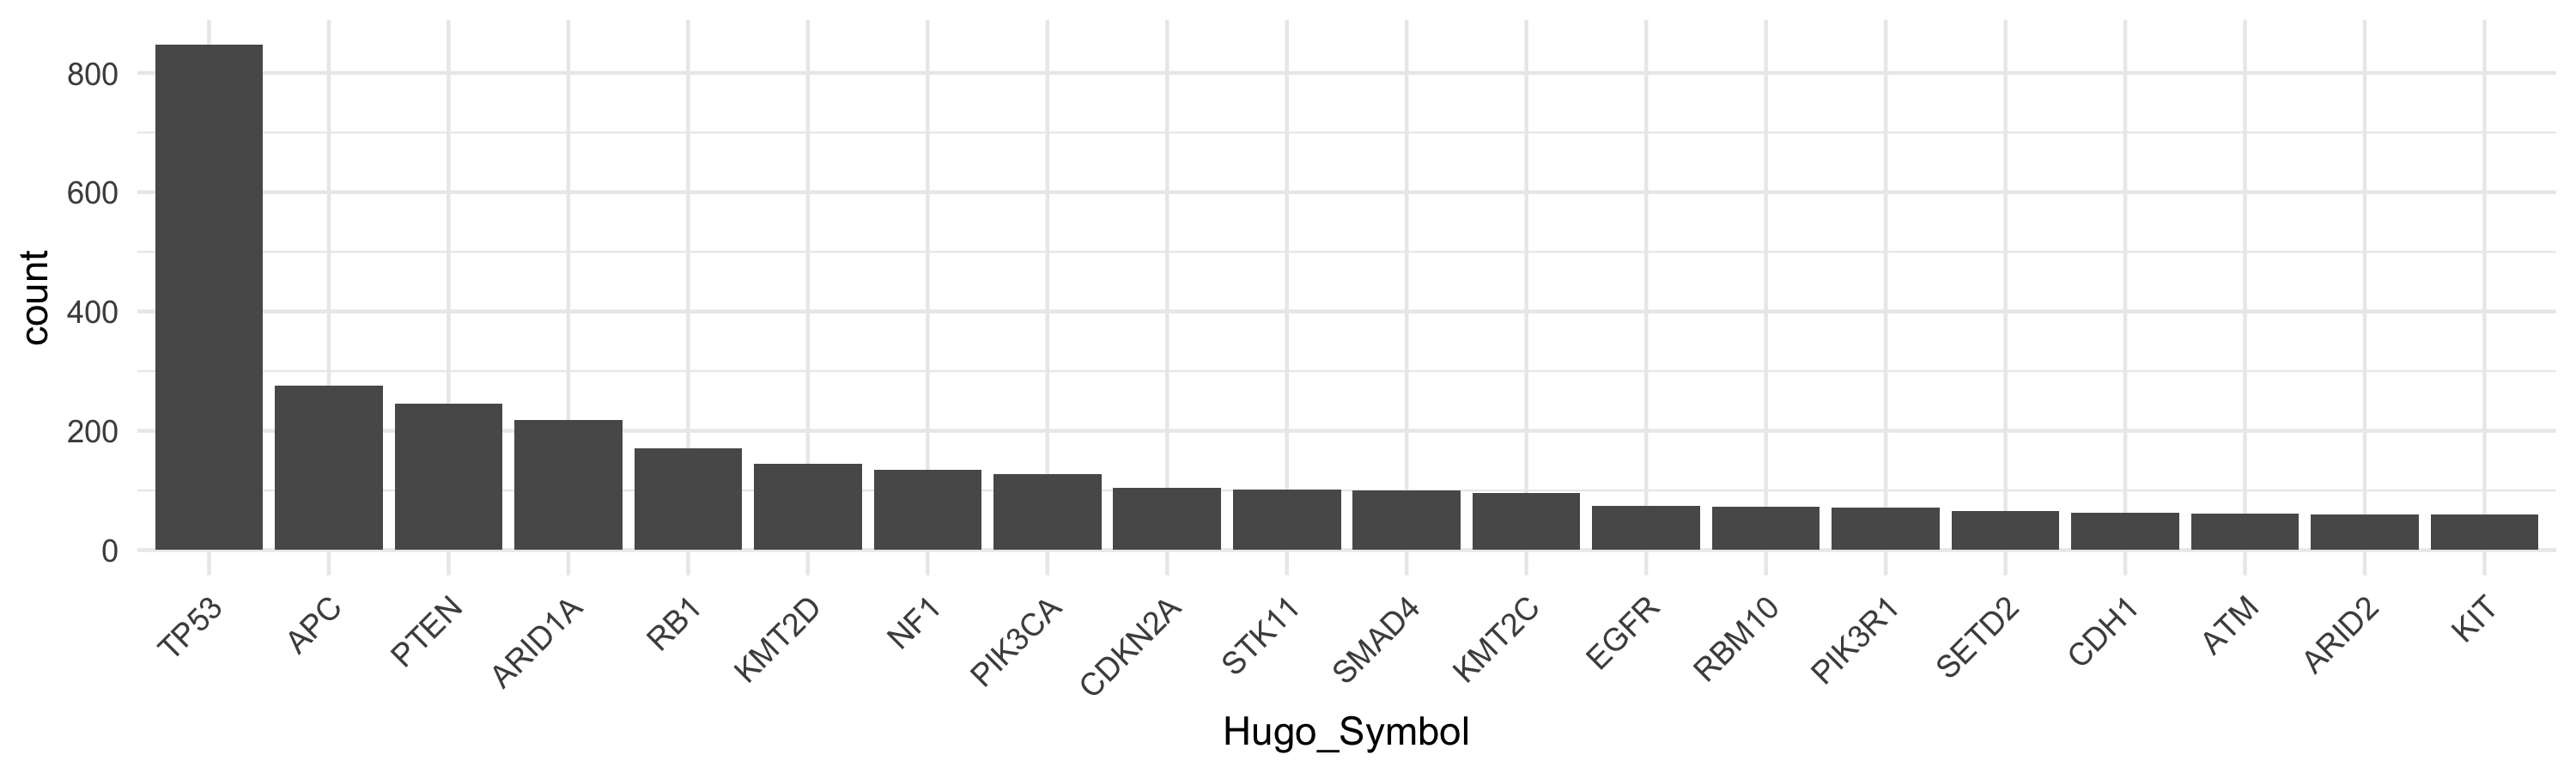

In [35]:
repeated_key <- sort_histogram(repeated_key, "Hugo_Symbol")
notebook_plot_size(10, 2)
ggplot(repeated_key) + geom_bar(aes(Hugo_Symbol)) + theme(axis.text.x = element_blank())
plot_histogram_top(repeated_key, "Hugo_Symbol", 20) + tilt_x_label_45()

Here is a plot of the genes that are the most mutated **accross the rows**:

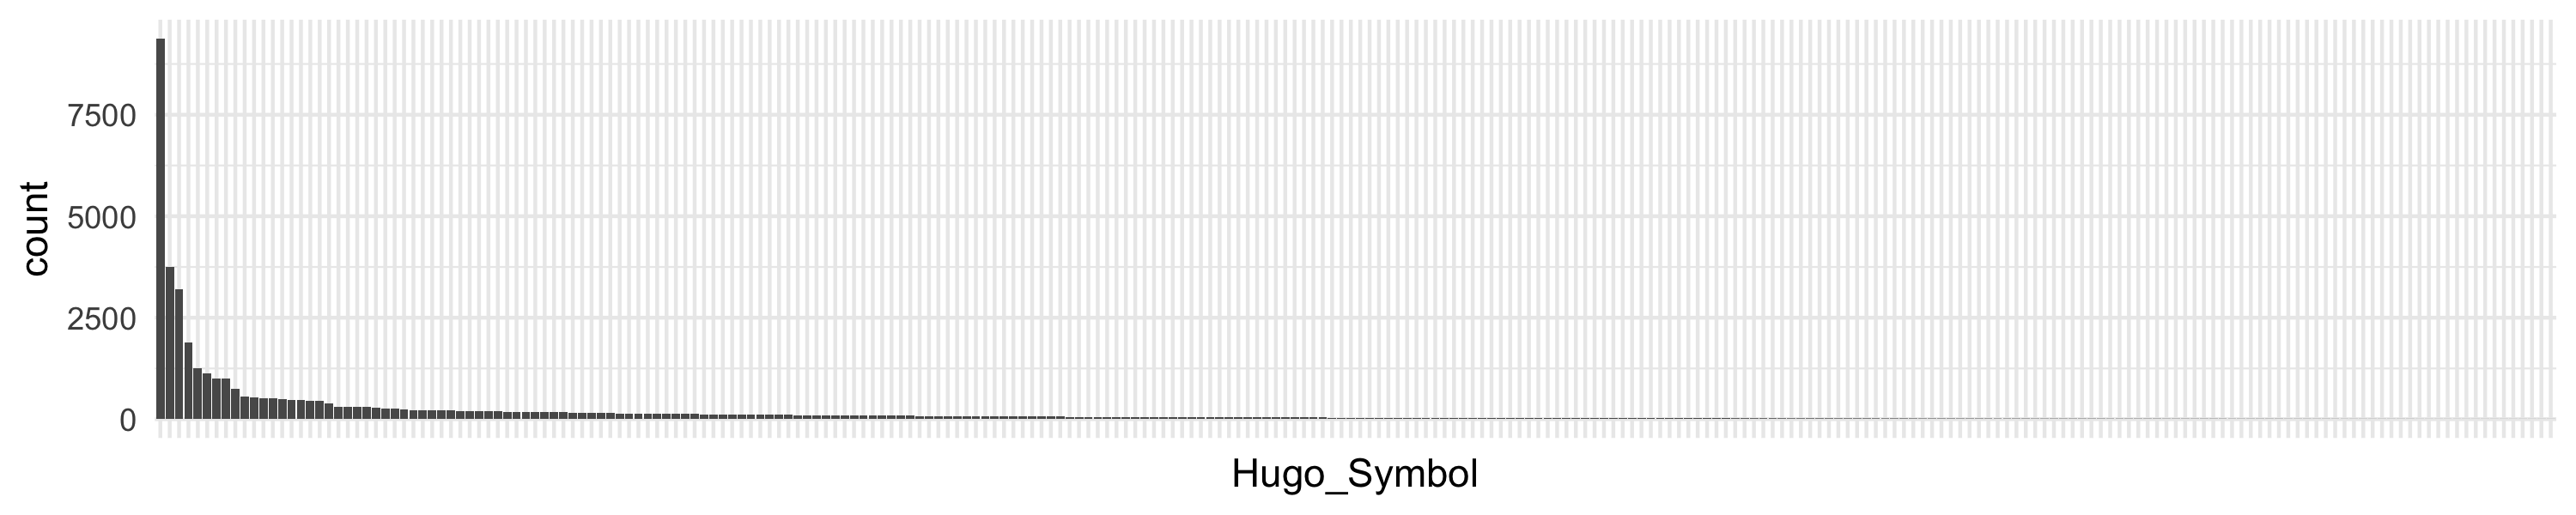

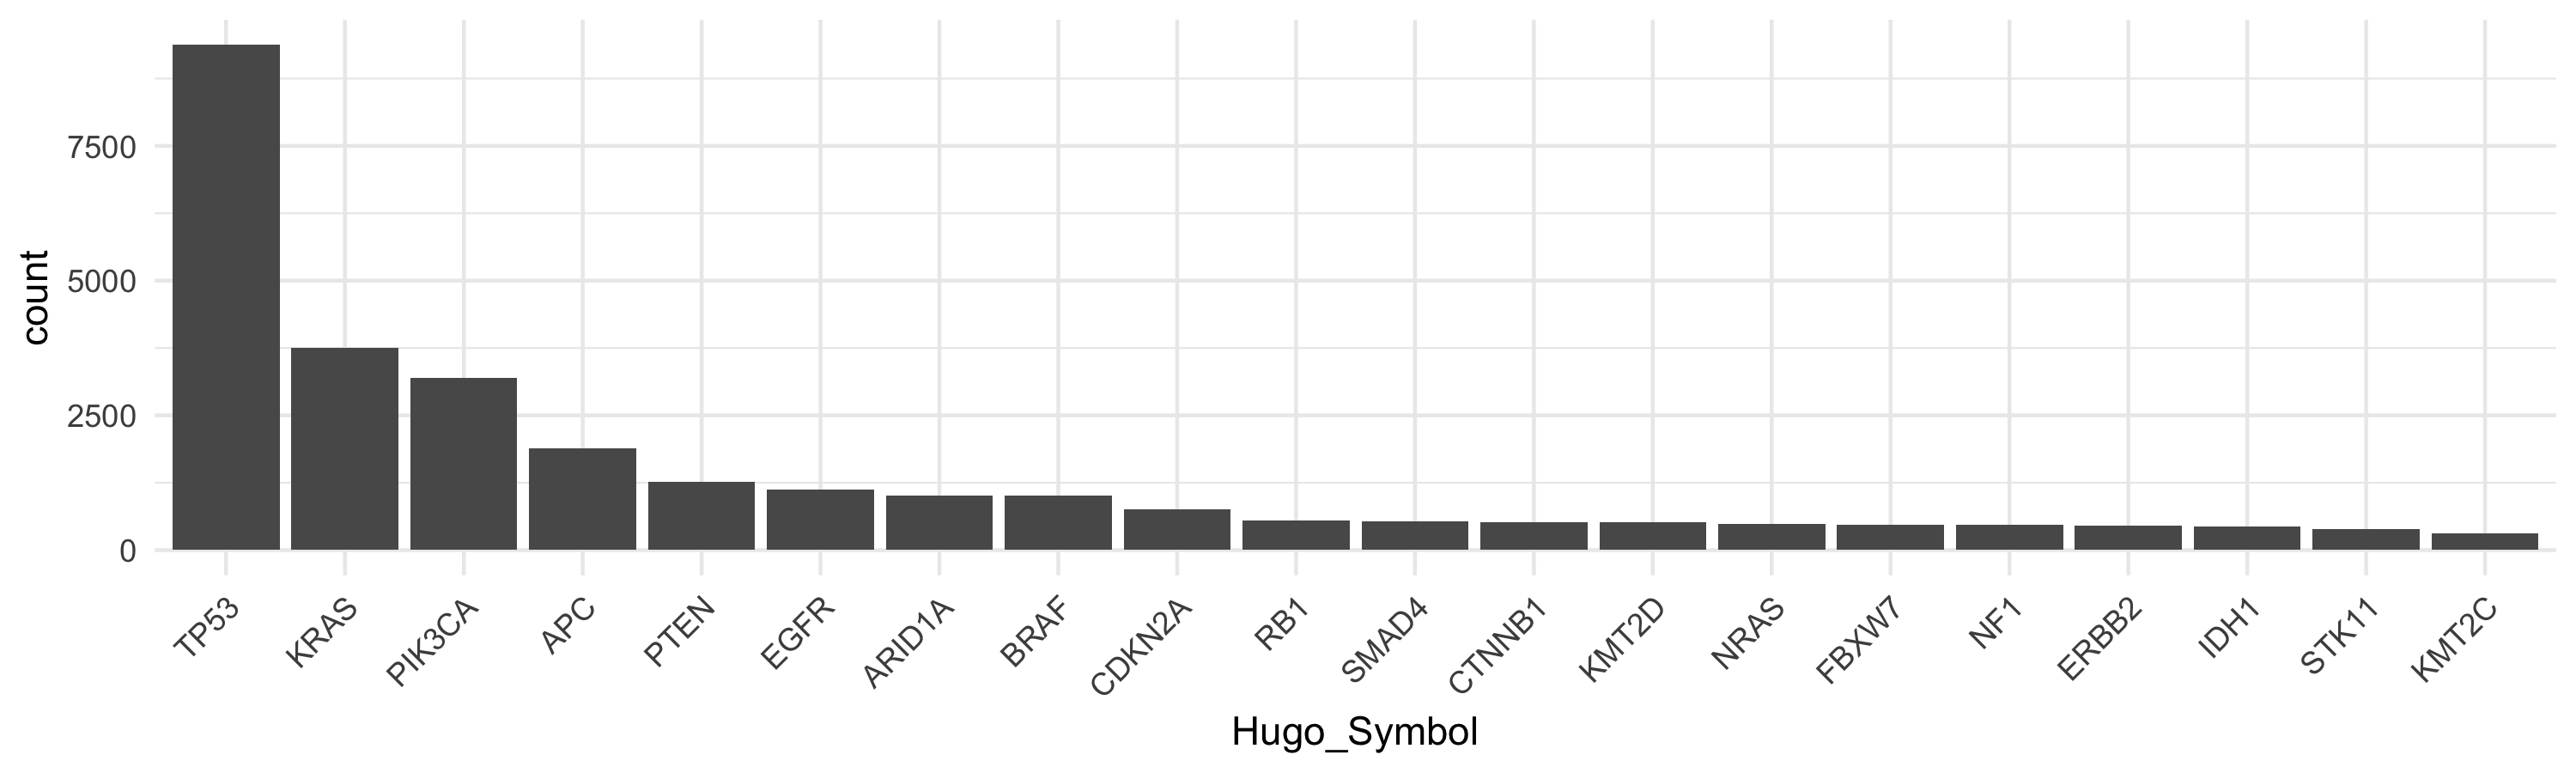

In [36]:
rec_impact <- impact_unique_mut_keys_per_patient[impact_unique_mut_keys_per_patient$mut_key %in% repeated_key$mut_key,]

rec_impact <- sort_histogram(rec_impact, "Hugo_Symbol")
notebook_plot_size(10, 2)
ggplot(rec_impact) + geom_bar(aes(Hugo_Symbol)) + theme(axis.text.x = element_blank())
plot_histogram_top(rec_impact, "Hugo_Symbol", 20) + tilt_x_label_45()

## Study of `is_a_hostpost`, `is_a_3d_hostpot`

We won't study the `is_a_3d_hotspot` feature as it is mostly included in the `is_a_hostpot` feature:

[1] "925 over 198259 (0.47%)"

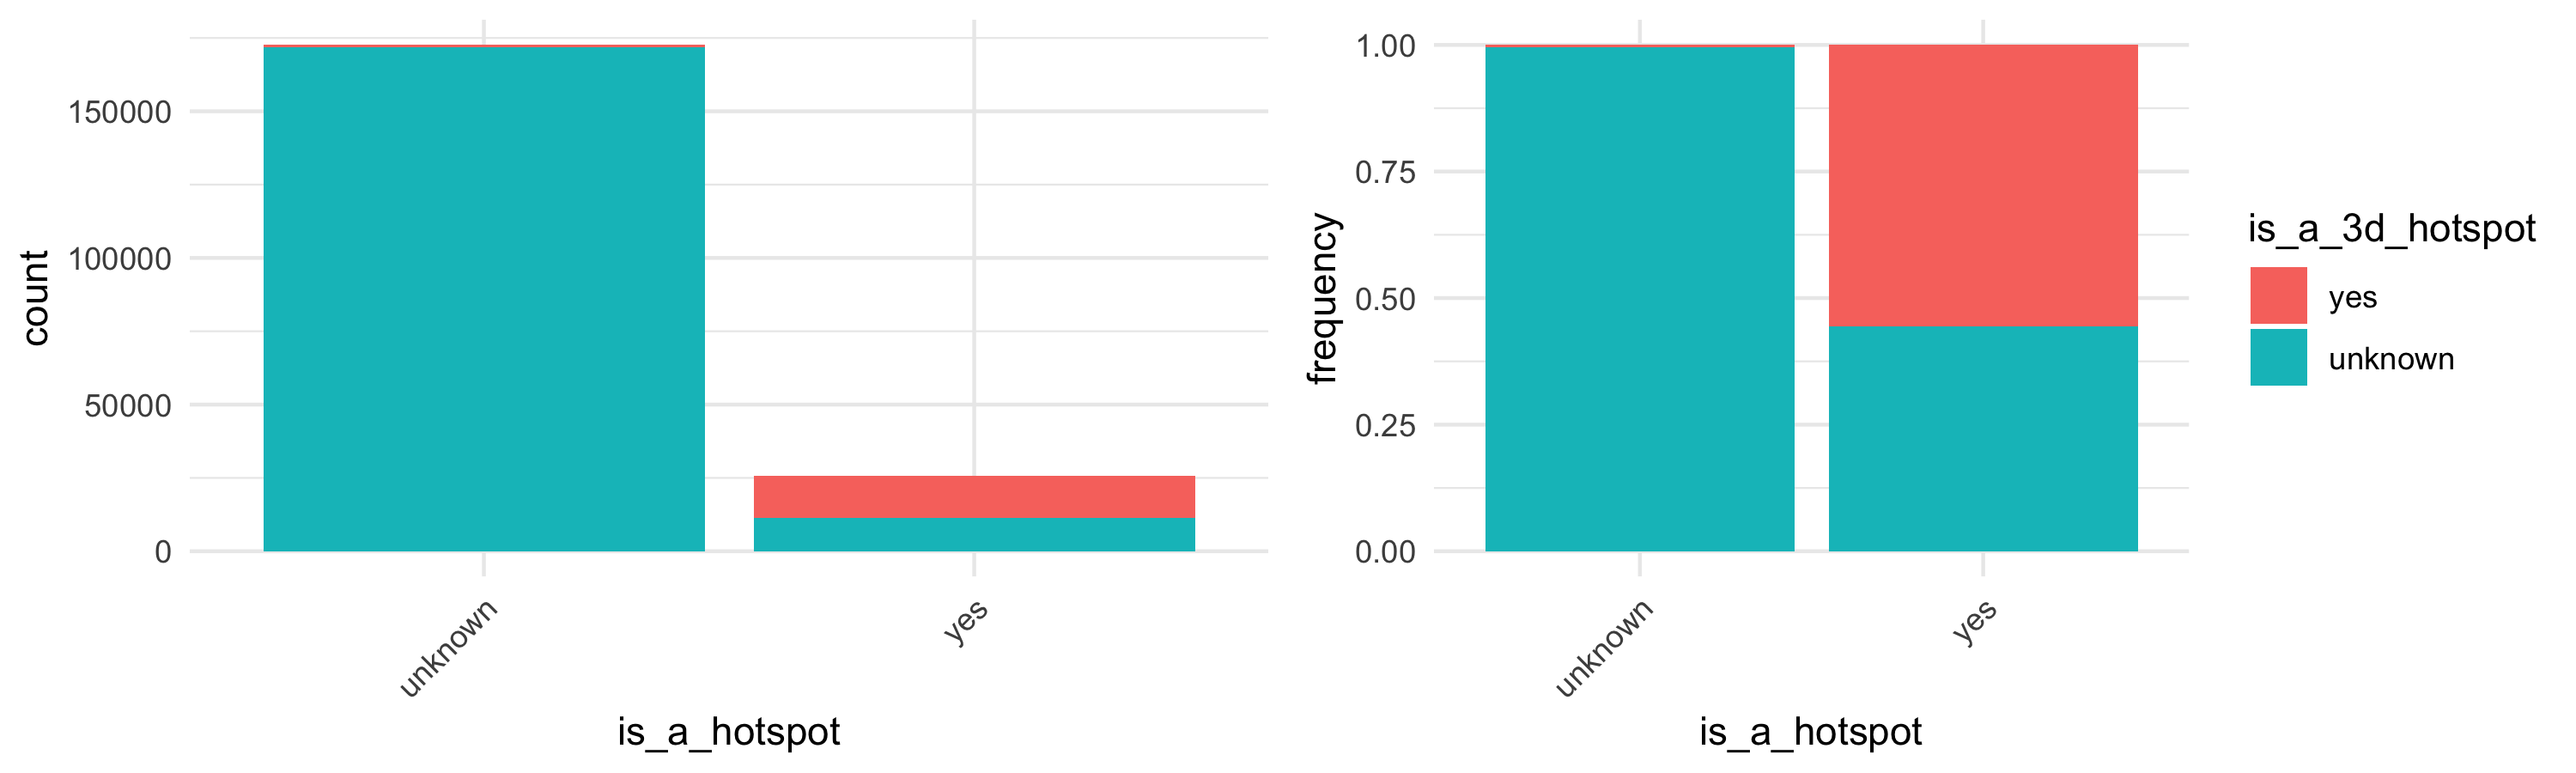

In [37]:
# number of 3d_hotspot mutations not being simple hotspot among the dataset
print_count_and_proportion(nrow(impact[impact$is_a_3d_hotspot == "yes" & impact$is_a_hotspot == "unknown",]),
                           nrow(impact))
plot_contingency_table_as_histograms(impact, "is_a_hotspot", "is_a_3d_hotspot")

It seems that the hostpot study focuses only on the `nonsynonymous_SNV` mutations:


unknown     yes 
 172627   25632 

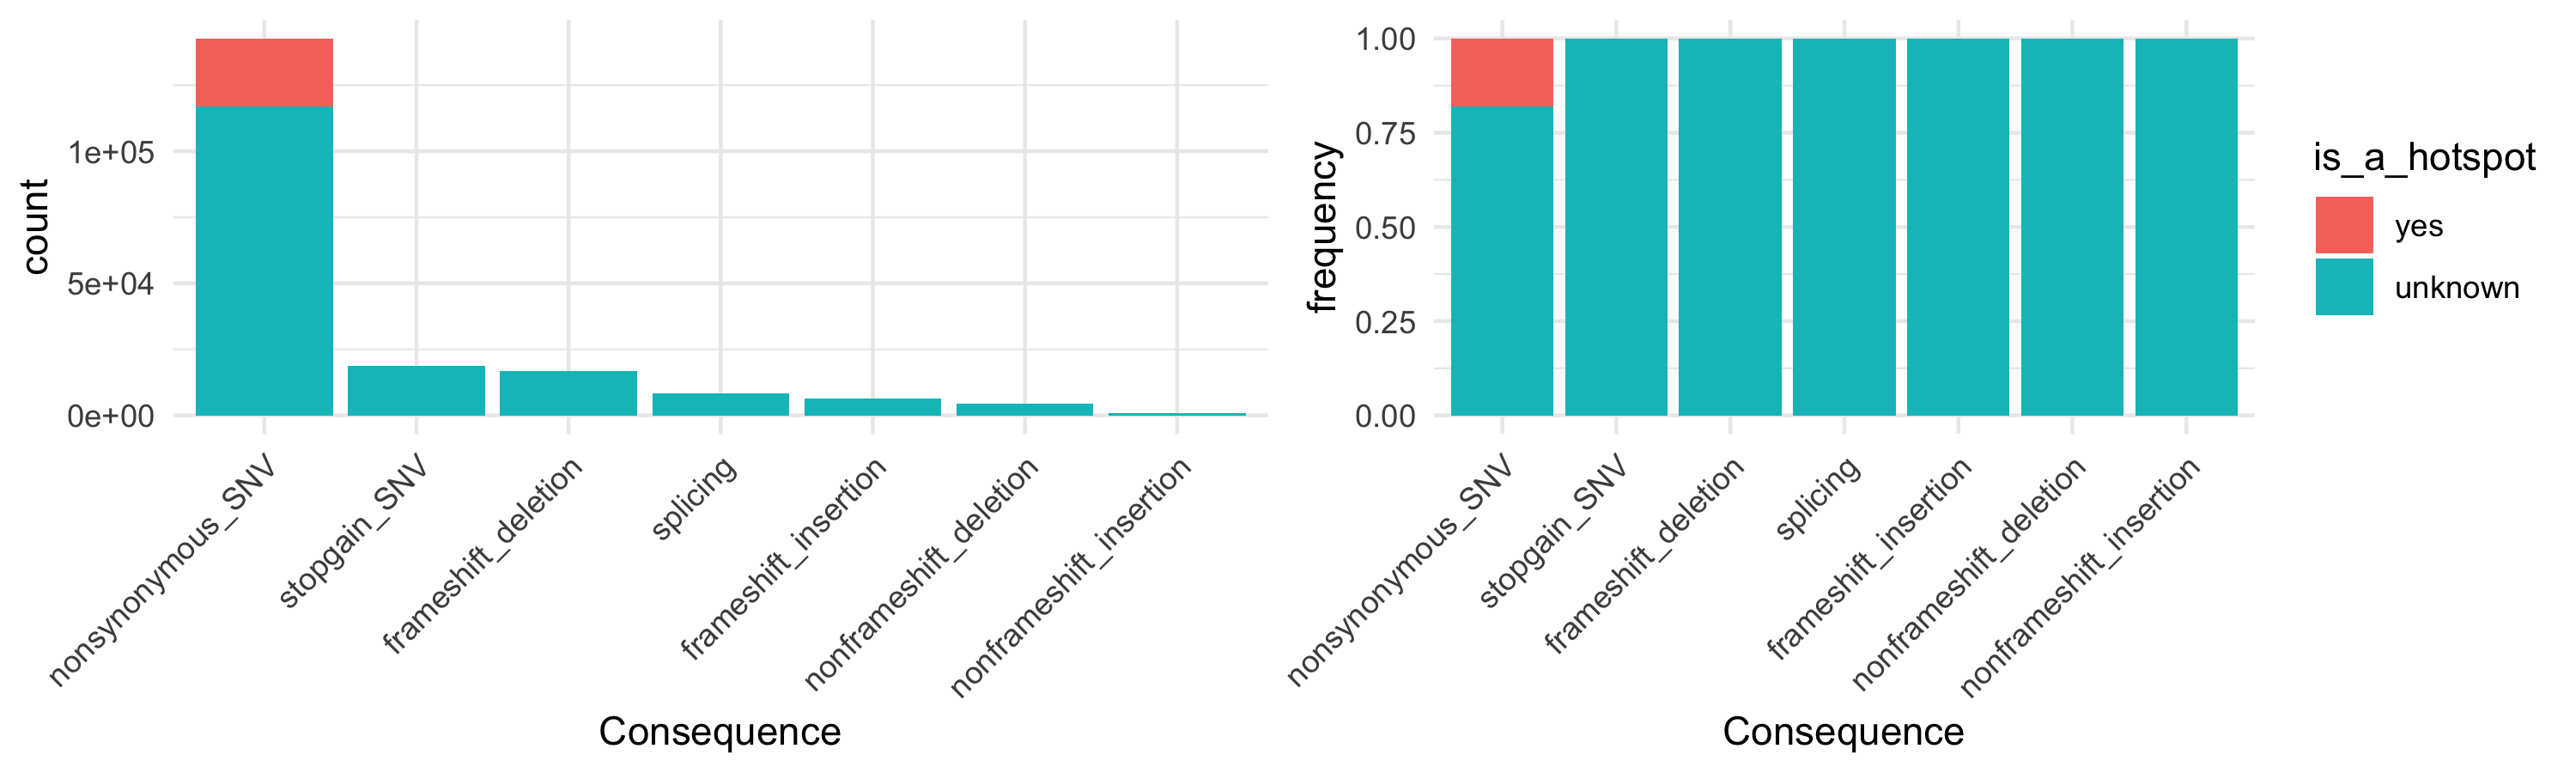

In [38]:
table(impact$is_a_hotspot)
plot_contingency_table_as_histograms(impact, "Consequence", "is_a_hotspot")

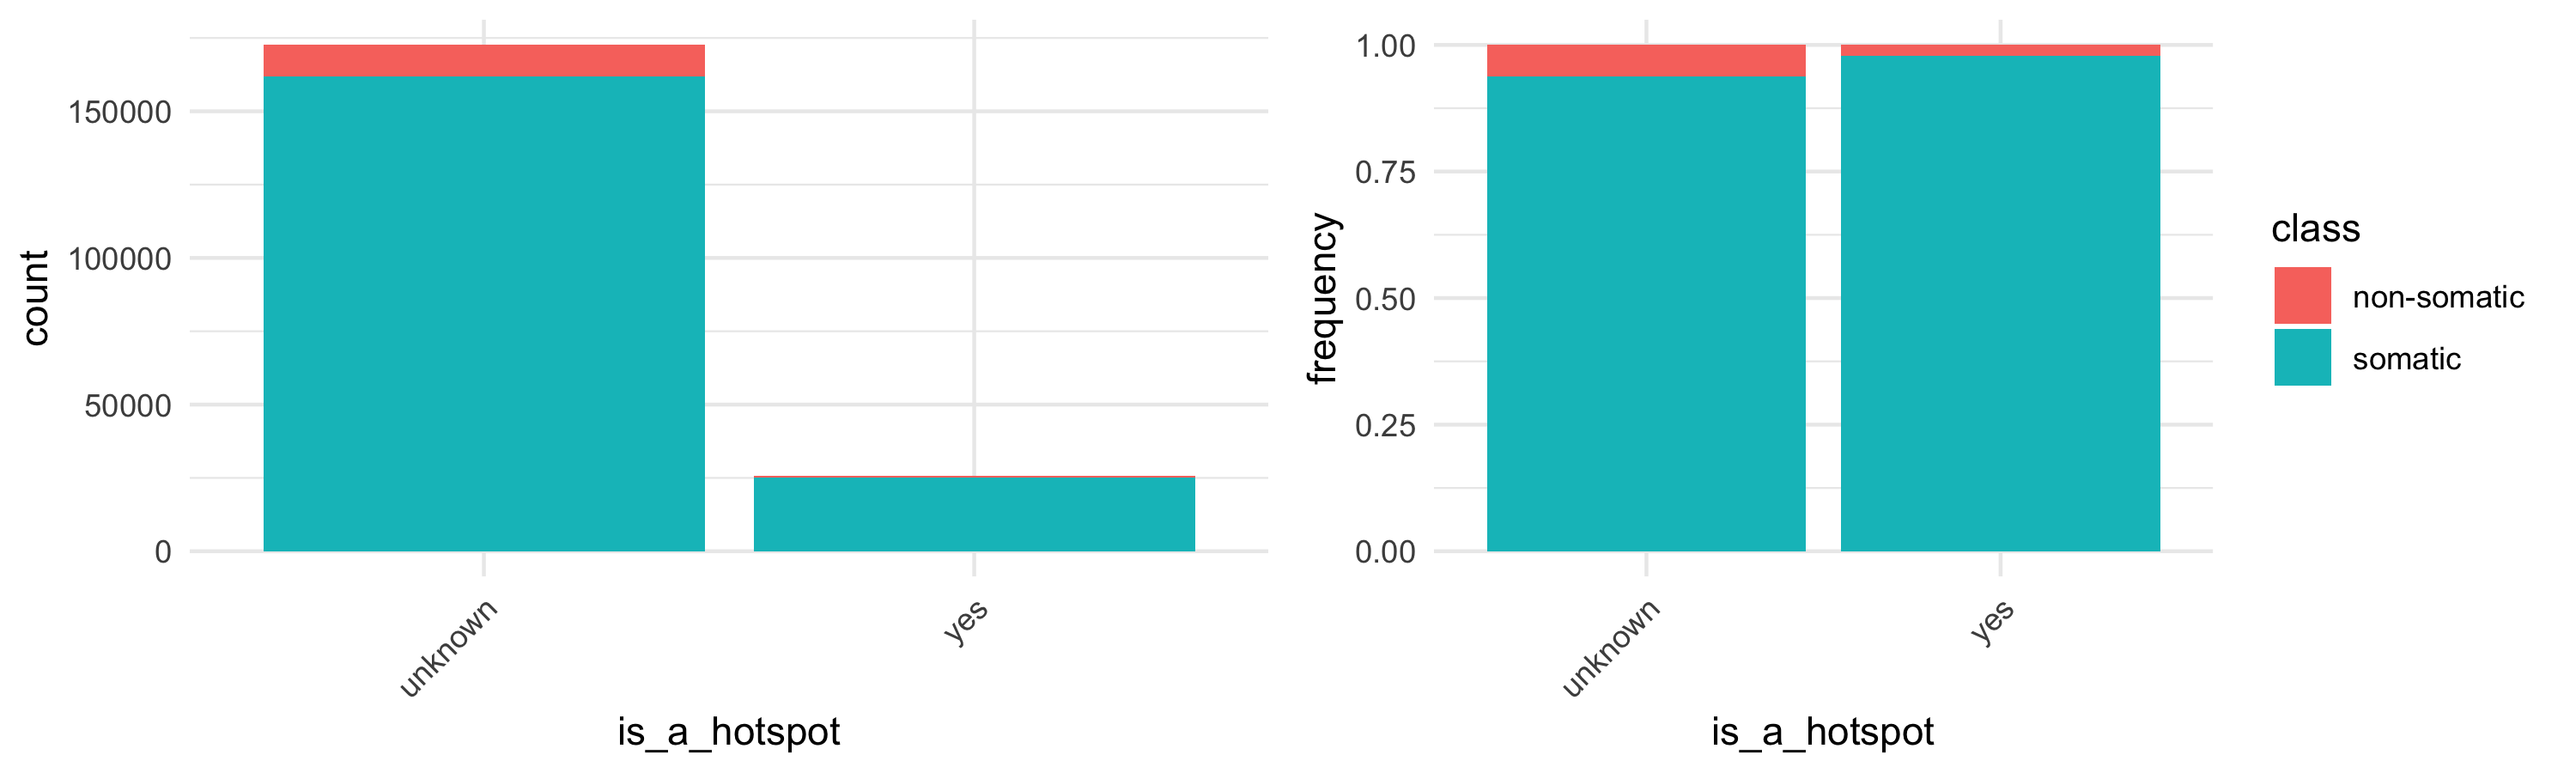

In [39]:
plot_contingency_table_as_histograms(impact[impact$class != "unknown",], "is_a_hotspot", "class")

Every variant in cancerhotspot is in OncoKB:

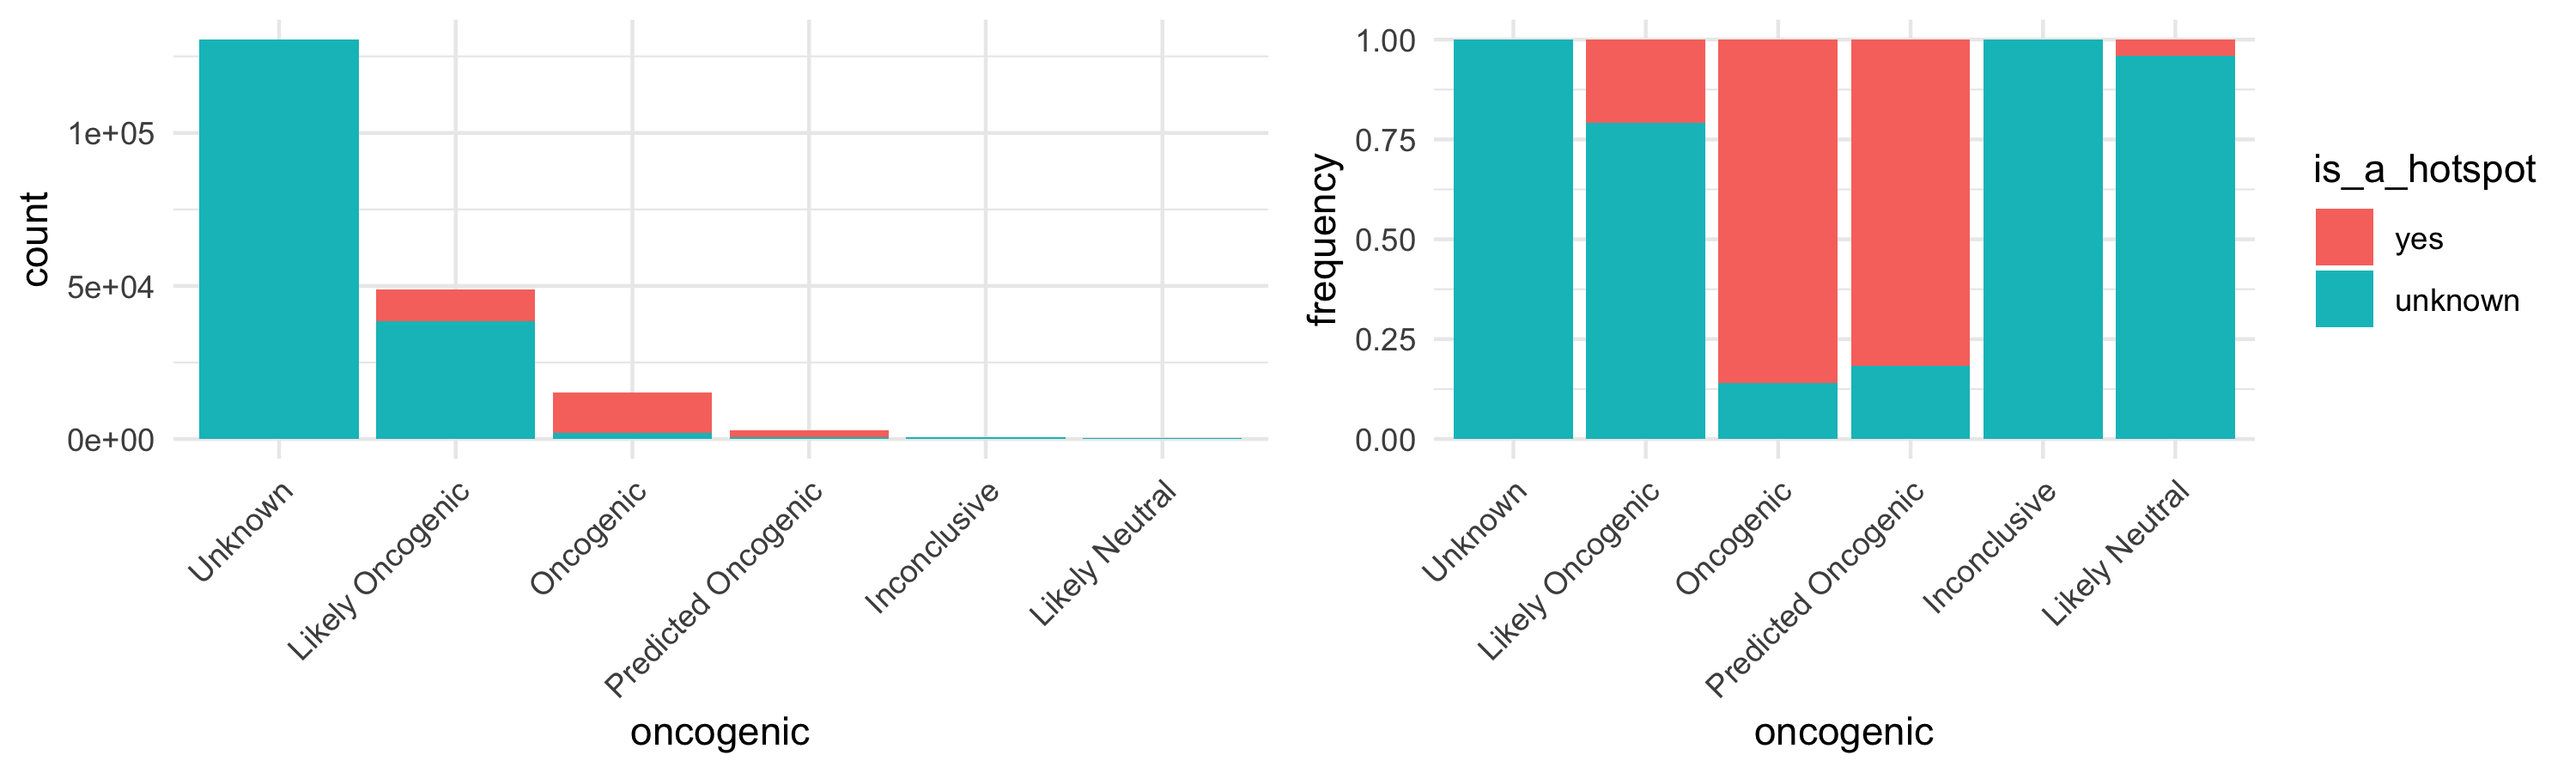

In [40]:
plot_contingency_table_as_histograms(impact, "oncogenic", "is_a_hotspot")

In [41]:
impact %>% filter(driver == "no" & is_a_hotspot == "yes") %>%
           group_by(mut_key) %>%
           summarise(count = n(),
                     Hugo_Symbol = unique(Hugo_Symbol),
                     HGVSp_Short = unique(HGVSp_Short),
                     oncogenic = unique(oncogenic))

mut_key,count,Hugo_Symbol,HGVSp_Short,oncogenic
14_152419926_TAGG_GAGC,1,FOXA1,p.S242_Y243delinsCS,Unknown
14_1632558_TAGG_GAGC,1,FOXA1,p.S242_Y243delinsCS,Unknown
14_178952084_TAGG_GAGC,1,FOXA1,p.S242_Y243delinsCS,Unknown
14_38060784_TAGG_GAGC,1,FOXA1,p.S242_Y243delinsCS,Unknown
14_65544745_CCC_TTT,1,MAX,p.R60_A61delinsQT,Unknown
3_178916957_G_A,1,PIK3CA,p.R115Q,Likely Neutral
3_178916957_G_C,5,PIK3CA,p.R115P,Likely Neutral
3_178916957_G_T,3,PIK3CA,p.R115L,Likely Neutral
3_178922321_G_A,4,PIK3CA,p.G364R,Likely Neutral
3_178922322_G_C,1,PIK3CA,p.G364A,Likely Neutral


## Study of `gene_type`

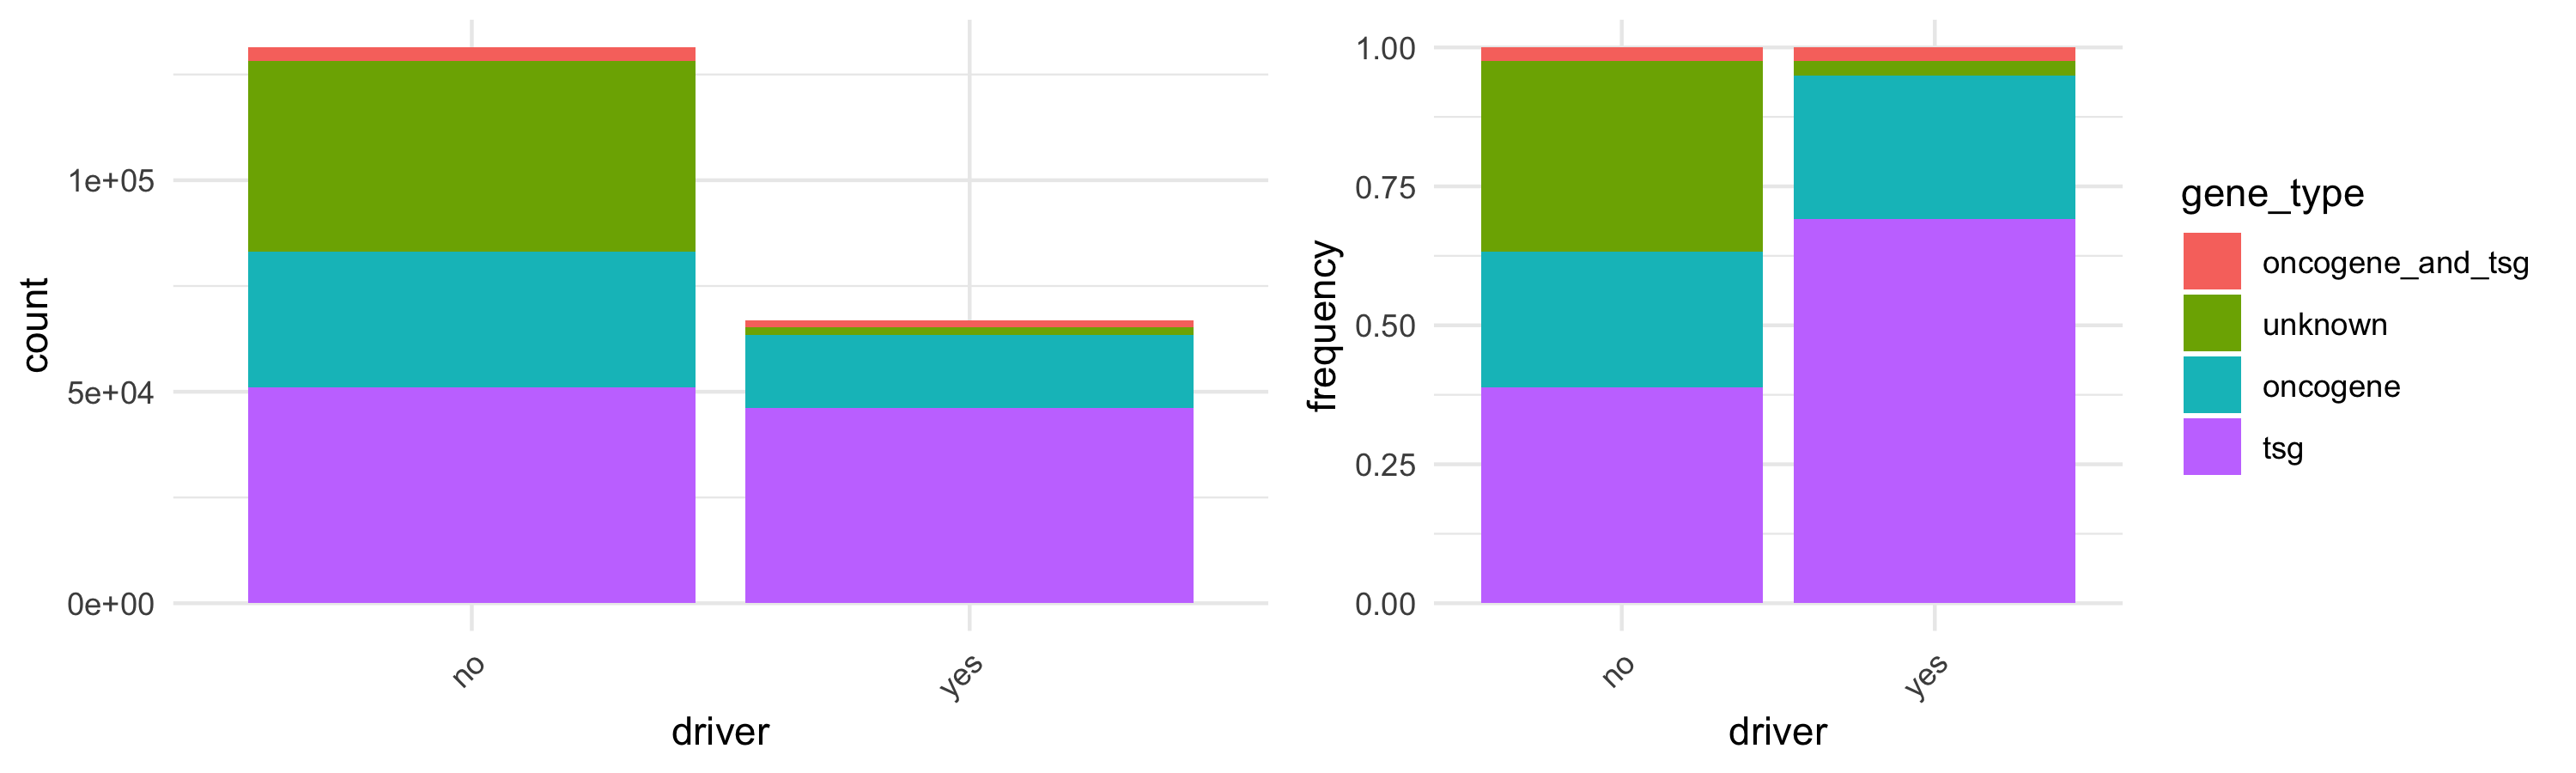

In [42]:
plot_contingency_table_as_histograms(impact, "driver", "gene_type")

Just a few variants are not in oncoKB but are truncated events in TSG genes, and a third of them comes from the gene `ZFHX3` which [doesn't show any variant](http://oncokb.org/#/gene/ZFHX3) in OncoKB:

In [43]:
truncating_mutations <- c("frameshift_deletion", "frameshift_insertion", "stopgain_SNV", "splicing")

# number of truncating event in TSG genes not being driver among the truncating event in TSG genes
trunc_tsg_but_not_drivers <- impact[impact$Consequence %in% truncating_mutations &
                                    impact$gene_type == "tsg" &
                                    impact$driver == "no",]

print_count_and_proportion(nrow(trunc_tsg_but_not_drivers), nrow(impact[impact$Consequence %in% truncating_mutations &
                                                                        impact$gene_type == "tsg",]))
table(trunc_tsg_but_not_drivers$Hugo_Symbol)

[1] "967 over 35278 (2.74%)"


  CYLD  ERCC2   FLCN   INHA  MUTYH  PALB2  POLD1   POLE RECQL4   SDHA   SDHC 
    47     34     77     17     32     85     84    114     63     27      7 
  SDHD   SPOP  ZFHX3 
     4     18    358 

## Annotate without oncokb-annotator

We are going to try to annotate our dataset without using oncokb-annotator but rather "by hand" using the raw OncoKB dataset dowloaded [here](http://oncokb.org/#/dataAccess) (blue button "ALL VARIANTS") on 06/08/18. We follow the methodology described in `annotate_cleaned_dataset.ipynb`.

We will only work on the coding mutations:

In [44]:
impact <- impact[impact$Consequence != "synonymous_SNV",]

### Get the raw data

In [45]:
oncokb <- read.table("../../../data/other_databases/allAnnotatedVariants.txt",
                     sep = "\t", stringsAsFactors = FALSE, header = TRUE, fill = TRUE)

The line 3790 have two extra `3'` coming from nowhere, we remove them (it causes the importation to fail if we don't add `fill = TRUE` to `read.table`).

In [46]:
oncokb[3790,]
(oncokb[3790,] <- oncokb[3790,] %>% mutate(Isoform         = "ENST00000263735",
                                           RefSeq          = "NM_002354.2",
                                           Entrez.Gene.ID  = 4072,
                                           Gene            = "EPCAM",
                                           Alteration      = "Deletion",
                                           Protein.Change  = "Deletion",
                                           Oncogenicity    = "Oncogenic",
                                           Mutation.Effect = "Loss-of-function"))

,Isoform,RefSeq,Entrez.Gene.ID,Gene,Alteration,Protein.Change,Oncogenicity,Mutation.Effect,PMIDs.for.Mutation.Effect,Abstracts.for.Mutation.Effect
3790,ENST00000269305,NM_000546.5,7157,TP53,H178D,H178D,Likely Oncogenic,Likely Loss-of-function,24814347,


Isoform,RefSeq,Entrez.Gene.ID,Gene,Alteration,Protein.Change,Oncogenicity,Mutation.Effect,PMIDs.for.Mutation.Effect,Abstracts.for.Mutation.Effect
ENST00000263735,NM_002354.2,4072,EPCAM,Deletion,Deletion,Oncogenic,Loss-of-function,24814347,


In [47]:
head(oncokb)

Isoform,RefSeq,Entrez.Gene.ID,Gene,Alteration,Protein.Change,Oncogenicity,Mutation.Effect,PMIDs.for.Mutation.Effect,Abstracts.for.Mutation.Effect
ENST00000318560,NM_005157.4,25,ABL1,BCR-ABL1 Fusion,BCR-ABL1 Fusion,Oncogenic,Gain-of-function,"11345193, 18851712",
ENST00000318560,NM_005157.4,25,ABL1,D276G,D276G,Oncogenic,Gain-of-function,15510211,
ENST00000318560,NM_005157.4,25,ABL1,E255K,E255K,Likely Oncogenic,Likely Gain-of-function,15194504,
ENST00000318560,NM_005157.4,25,ABL1,E255V,E255V,Likely Oncogenic,Likely Gain-of-function,21562040,
ENST00000318560,NM_005157.4,25,ABL1,E279K,E279K,Likely Oncogenic,Likely Gain-of-function,21562040,
ENST00000318560,NM_005157.4,25,ABL1,E281K,E281K,Likely Oncogenic,Likely Gain-of-function,21193419,


###  Create keys to join the two dataframes and extract the features

We are going to identify each mutation with a key in both dataframes, allowing us to link each mutation from `impact` to its corresponding mutation in `oncokb`. The keys will be: 
* `Hugo_Symbol`.`HGVSp_Short` for `impact` or `Hugo_Symbol`.p.`Truncating Mutations` when the mutation is truncating (OncoKB notation)
* `Gene`.p.`Protein.Change` for `oncokb`

In [48]:
# create the oncokb `join_key`
oncokb$join_key <- paste0(oncokb$Gene, '.p.',oncokb$Protein.Change)

# create the impact `oncokb_key`
impact$oncokb_key <- paste0(impact$Hugo_Symbol, '.', impact$HGVSp_Short)

is_truncating <- which(impact$Consequence %in% c("frameshift_deletion",
                                                 "frameshift_insertion",
                                                 "stopgain_SNV",
                                                 "splicing"))
impact$oncokb_key[is_truncating] <- paste0(impact$Hugo_Symbol[is_truncating], '.p.Truncating Mutations')

In [49]:
head(oncokb$join_key)
head(impact$oncokb_key)

[1] "ABL1.p.BCR-ABL1 Fusion" "ABL1.p.D276G"           "ABL1.p.E255K"          
[4] "ABL1.p.E255V"           "ABL1.p.E279K"           "ABL1.p.E281K"

[1] "TP53.p.T256P"                 "PIK3R3.p.I298M"              
[3] "ATR.p.R2431M"                 "PDGFRA.p.L465M"              
[5] "FBXW7.p.Truncating Mutations" "FBXW7.p.Truncating Mutations"

**Verification 1** The feature `Oncogenicity` is unique for each `join_key`:

In [50]:
nrow(oncokb %>% group_by(join_key) %>% filter(length(unique(Oncogenicity)) > 1))
oncokb <- unique(oncokb[, c("join_key", "Oncogenicity")])
head(oncokb, 4)

[1] 0

join_key,Oncogenicity
ABL1.p.BCR-ABL1 Fusion,Oncogenic
ABL1.p.D276G,Oncogenic
ABL1.p.E255K,Likely Oncogenic
ABL1.p.E255V,Likely Oncogenic


**Verification 2** Some impact `oncokb_key` don't have an analoguous `join_key` in `oncokb`, some `NA` values will appear and need to be handled:

In [51]:
nrow(impact[! impact$oncokb_key %in% oncokb$join_key,])

[1] 140454

In [52]:
impact[, c("oncogenicity")] <- left_join(impact, oncokb,
                                         by = c("oncokb_key" = "join_key"))[, c("Oncogenicity")]

### Compare `oncogenicity` with `oncogenic`

In [53]:
impact$oncogenicity[is.na(impact$oncogenicity)] <- "Unknown"
table(impact$oncogenicity)


    Inconclusive   Likely Neutral Likely Oncogenic        Oncogenic 
             525              239            42995            14046 
         Unknown 
          140454 

Let's compare oncokb-annotator with our raw linking:

In [54]:
print_count_and_proportion(nrow(impact[impact$oncogenic    != "Unknown",]), nrow(impact))
print_count_and_proportion(nrow(impact[impact$oncogenicity != "Unknown",]), nrow(impact))

[1] "67764 over 198259 (34.18%)"

[1] "57805 over 198259 (29.16%)"

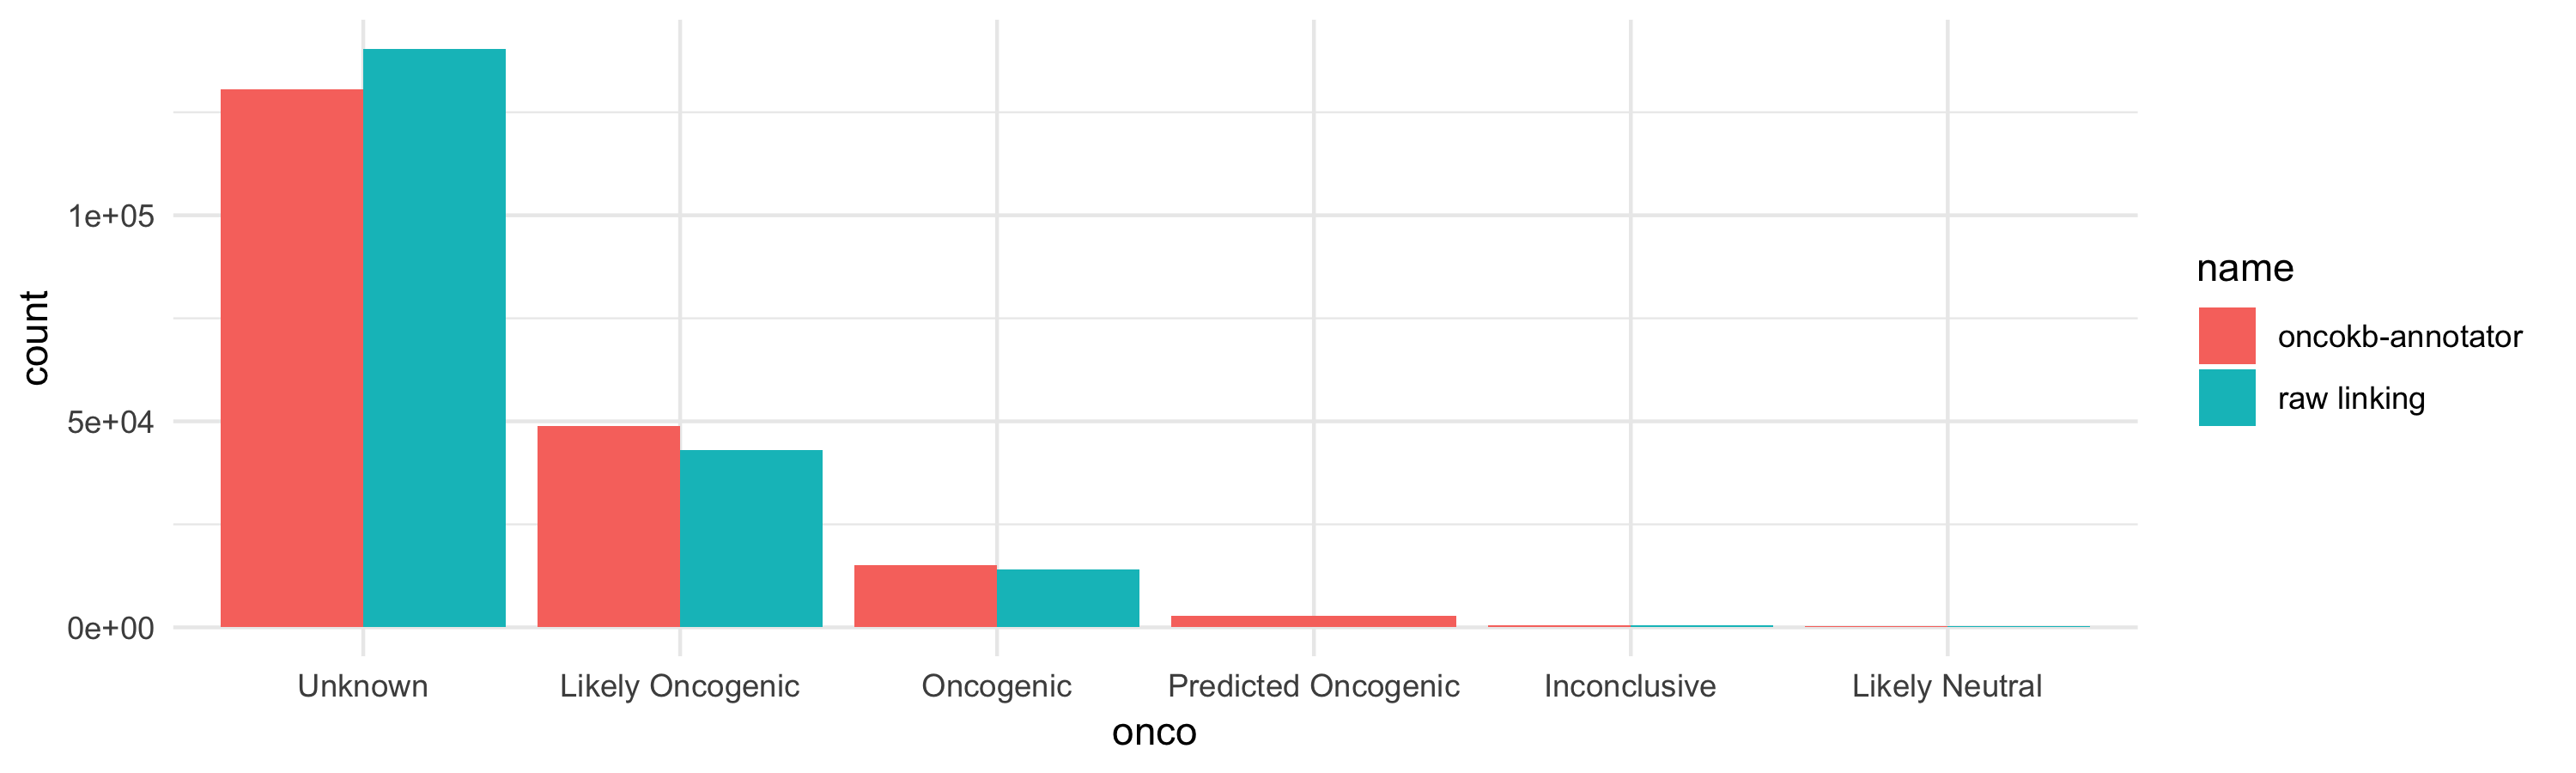

In [55]:
dd_1 <- data.frame(impact$oncogenic, "oncokb-annotator")
colnames(dd_1) <- c("onco", "name")
dd_1 <- sort_histogram(dd_1, "onco")
dd_2 <- data.frame(impact$oncogenicity, "raw linking")
colnames(dd_2) <- c("onco", "name")
dd_2 <- sort_histogram(dd_2, "onco")

ggplot(rbind(dd_1, dd_2)) + geom_bar(aes(x = onco, fill = name), position = "dodge")

## Study of the alternative amino-acid

In this section we are going to study if the alternative amino-acid changes are also considered by oncokb-annotator, for example, if `SRSF2.p.P95H` is in OncoKB, is `SRSF2.p.P95R` also in OncoKB? It will only focus on the single acid substitution. The following function returns, for a given key, the list of the alternative amino-acid keys in OncoKB:

In [56]:
amino_acid_list = c('A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I',
                    'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V')

get_alternative_keys_in_oncokb <- function(key) {

    # check if single acid substitution (p.T256P)
    if (grepl("\\.p\\.[A-Z][0-9]{1,4}[A-Z]$", key)) {

        alternative_amino_acid_list <- amino_acid_list[amino_acid_list != substr(key, nchar(key), nchar(key))]
        alternative_keys <- paste0(substr(key, 1, nchar(key)-1), alternative_amino_acid_list)
        in_oncokb <- which(alternative_keys %in% oncokb$join_key)
        
        if (any(alternative_keys %in% oncokb$join_key))
            return (c(key, alternative_keys[in_oncokb]))
    }
    
    return ('')
}

get_alternative_keys_in_oncokb("MAP2K4.p.S251A")
get_alternative_keys_in_oncokb("TP53.p.T256P")
get_alternative_keys_in_oncokb('FBXW7.p.Truncating Mutations')

[1] "MAP2K4.p.S251A" "MAP2K4.p.S251N"

[1] ""

[1] ""

Let's see if some of the unknown mutations would have been in OncoKB if they were resulting in an alternative amino_acid:

In [57]:
dd <- sapply(unique(impact$oncokb_key[impact$oncogenic == "Unknown"]), get_alternative_keys_in_oncokb)
dd <- unique(dd[dd != ''])
length(dd)

[1] 0

Apparently oncokb-annotator takes this into account.